In [1]:
from predict import perform_inference
from celeba_loader import create_dataloaders
from train import train, write_model, save_model

import torch

In [2]:
DEVICE = 1
device = torch.device(f'cuda:{DEVICE}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [3]:
EPOCHS = 5
LEARNING_RATE = 0.01
RATIO = 0.8
BATCH_SIZE = 32
DEVICE = 1

# Train models on compressed celebA images

In [4]:
COMPRESSED_IMAGE_PATH = '/media/global_data/fair_neural_compression_data/decoded_celeba/progressive/qres17m/q_64'
data_rates = [1, 3, 6, 9, 12]
lambda_value = 64

In [5]:
compressed_data_loaders = []
for data_rate in data_rates:
    trainloader, testloader = create_dataloaders(f"{COMPRESSED_IMAGE_PATH}/{data_rate}", "../data/celebA/attr/list_attr_celeba.txt", BATCH_SIZE, RATIO, png=True)
    compressed_data_loaders.append([trainloader, testloader])

In [6]:
def save_model(model, dir_path, model_name):
    filename = f"{dir_path}/{model_name}.pth"
    print("Writing Model")
    torch.save(model, filename)
    print("Model Saved")

In [7]:
trained_models = []
for data_rate, [train_loader, test_loader] in zip(data_rates, compressed_data_loaders):
    trained_model = train(EPOCHS, LEARNING_RATE, train_loader, DEVICE)
    trained_models.append(trained_model)
    model_save_path = f'../models'
    model_name = f'celebA_resnet18_lambda={lambda_value}_data_rate={data_rate}'
    save_model(trained_model, model_save_path, model_name)

Using Device  cuda:1


Using cache found in /home/rasta/.cache/torch/hub/pytorch_vision_v0.10.0
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|█████████▉| 5064/5065 [04:05<00:00, 20.63batch/s, loss=0.408]/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnn

Writing Model
Model Saved
Using Device  cuda:1


Epoch 5/5: 100%|██████████| 5065/5065 [03:51<00:00, 21.85batch/s, loss=0.345]
Using cache found in /home/rasta/.cache/torch/hub/pytorch_vision_v0.10.0


Writing Model
Model Saved
Using Device  cuda:1


Epoch 5/5: 100%|██████████| 5065/5065 [03:51<00:00, 21.90batch/s, loss=0.291]
Using cache found in /home/rasta/.cache/torch/hub/pytorch_vision_v0.10.0


Writing Model
Model Saved
Using Device  cuda:1


Epoch 5/5: 100%|██████████| 5065/5065 [04:04<00:00, 20.71batch/s, loss=0.281]
Using cache found in /home/rasta/.cache/torch/hub/pytorch_vision_v0.10.0


Writing Model
Model Saved
Using Device  cuda:1


Epoch 5/5: 100%|██████████| 5065/5065 [03:29<00:00, 24.16batch/s, loss=0.256]


Writing Model
Model Saved


In [8]:
attr_path = '/home/rasta/fair-neural-compression-eval/data/celebA/attr/list_attr_celeba.txt'
LINE_PADDING = 2
attr_table = open(attr_path).readlines()[LINE_PADDING:]
column_labels = open(attr_path).readlines()[1]
attr = [row.split() for row in attr_table]

In [9]:
column_labels = open(attr_path).readlines()[1]
column_labels = column_labels.strip().split()
gender_index = column_labels.index('Male')
gender_index

20

In [10]:
from tqdm import tqdm

def save_male_female_predictions(
        model, 
        model_name, 
        testloader, 
        device, 
        gender_index, 
        prediction_save_dir,
        save_labels=False
    ):
    predictions_female = torch.Tensor().to(device)
    predictions_male = torch.Tensor().to(device)
    labels_male, labels_female = torch.Tensor().to(device), torch.Tensor().to(device)
    
    print(f'prediction_save_dir: {prediction_save_dir}')
    testloader = tqdm(testloader, desc="Getting Predictions", unit="batch")
    
    for i, data in enumerate(testloader):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        predictions = outputs >= 0.5

        gender = labels[:, gender_index]
        predictions_female = torch.cat((predictions_female, predictions[gender == 0]), dim=0)
        predictions_male = torch.cat((predictions_male, predictions[gender == 1]), dim=0)
        
        labels_female = torch.cat((labels_female, labels[gender == 0]), dim=0)
        labels_male = torch.cat((labels_male, labels[gender == 1]), dim=0)

    # Save predictions
    torch.save(predictions_female, f'{prediction_save_dir}/{model_name}_predictions_female.pt')
    torch.save(predictions_male, f'{prediction_save_dir}/{model_name}_predictions_male.pt')
    if save_labels:
        torch.save(labels_female, f'{prediction_save_dir}/{model_name}_labels_female.pt')
        torch.save(labels_male, f'{prediction_save_dir}/{model_name}_labels_male.pt')
    
    return predictions_male, predictions_female, labels_male, labels_female


In [12]:
PRED_SAVE_DIR = '../results/celebA/predictions/output model preds'
preds = {data_rate: [] for data_rate in data_rates}
for i in range(len(compressed_data_loaders)):
    male_pred, female_pred, male_label, female_label = \
        save_male_female_predictions(
            trained_models[i], 
            f'celebA_resnet18_lambda={lambda_value}_data_rate={data_rates[i]}', 
            compressed_data_loaders[i][1], 
            device, 
            gender_index, 
            PRED_SAVE_DIR
        )
    preds[data_rates[i]]= [male_pred, female_pred, male_label, female_label]

prediction_save_dir: ../results/celebA/predictions/output model preds


Getting Predictions: 100%|██████████| 1267/1267 [00:41<00:00, 30.19batch/s]


prediction_save_dir: ../results/celebA/predictions/output model preds


Getting Predictions: 100%|██████████| 1267/1267 [00:41<00:00, 30.18batch/s]


prediction_save_dir: ../results/celebA/predictions/output model preds


Getting Predictions: 100%|██████████| 1267/1267 [00:41<00:00, 30.65batch/s]


prediction_save_dir: ../results/celebA/predictions/output model preds


Getting Predictions: 100%|██████████| 1267/1267 [00:41<00:00, 30.89batch/s]


prediction_save_dir: ../results/celebA/predictions/output model preds


Getting Predictions: 100%|██████████| 1267/1267 [00:42<00:00, 30.00batch/s]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


male_labels_path = '../results/celebA/predictions/labels_male.pt'
female_labels_path = '../results/celebA/predictions/labels_female.pt'

male_labels = torch.load(male_labels_path).to('cpu')
female_labels = torch.load(female_labels_path).to('cpu')
print(f'male_labels.shape: {male_labels.shape} - female_labels.shape: {female_labels.shape}')

results = {'accuracy': {}, 'f1': {}, 'precision': {}, 'recall': {}}

for data_rate in data_rates:
    dir_path = f'{PRED_SAVE_DIR}'
    model_name = f'celebA_resnet18_lambda={lambda_value}_data_rate={data_rate}'
    male_preds = torch.load(f'{dir_path}/{model_name}_predictions_male.pt').to('cpu')
    female_preds = torch.load(f'{dir_path}/{model_name}_predictions_female.pt').to('cpu')
    print(f'male_preds.shape: {male_preds.shape} - female_preds.shape: {female_preds.shape}')
    
    female_accuracy = torch.sum(female_preds == female_labels, axis=0) / female_preds.shape[0]
    male_accuracy = torch.sum(male_preds == male_labels, axis=0) / male_preds.shape[0]
    
    female_f1 = f1_score(female_labels, female_preds, average=None)
    male_f1 = f1_score(male_labels, male_preds, average=None)
    
    male_recall = recall_score(male_labels, male_preds, average=None)
    female_recall = recall_score(female_labels, female_preds, average=None)
    
    male_precision = precision_score(male_labels, male_preds, average=None)
    female_precision = precision_score(female_labels, female_preds, average=None)

    results['accuracy'][data_rate] = [male_accuracy, female_accuracy]
    results['f1'][data_rate] = [male_f1, female_f1]
    results['precision'][data_rate] = [male_precision, female_precision]
    results['recall'][data_rate] = [male_recall, female_recall]

# Plot results

In [22]:
results.keys()

dict_keys(['accuracy', 'f1', 'precision', 'recall'])

In [21]:
import json

ROOT = '/media/global_data/fair_neural_compression_data/decoded_celeba/progressive_64x64'
bpps = []
for data_rate in data_rates:
    json_path = f'{ROOT}/qres17m/q_{lambda_value}/{data_rate}/stats.json'
    with open(json_path, 'r') as json_file:
        data_dict = json.load(json_file)
        bpps.append(data_dict['results']['bpp'])

In [25]:
results['accuracy'][data_rate][j]

tensor([0.9997, 0.6947, 0.7715, 0.8984, 0.9999, 0.9254, 0.7014, 0.8958, 0.8825,
        0.8774, 0.9533, 0.8025, 0.9363, 0.9884, 0.9902, 0.9910, 0.9998, 0.9905,
        0.8074, 0.8733, 0.9696, 0.8907, 1.0000, 0.8850, 0.9980, 0.6874, 0.9527,
        0.6648, 0.9498, 0.8735, 0.9999, 0.9179, 0.7773, 0.6944, 0.7454, 0.9847,
        0.8650, 0.8000, 0.9984, 0.8933])

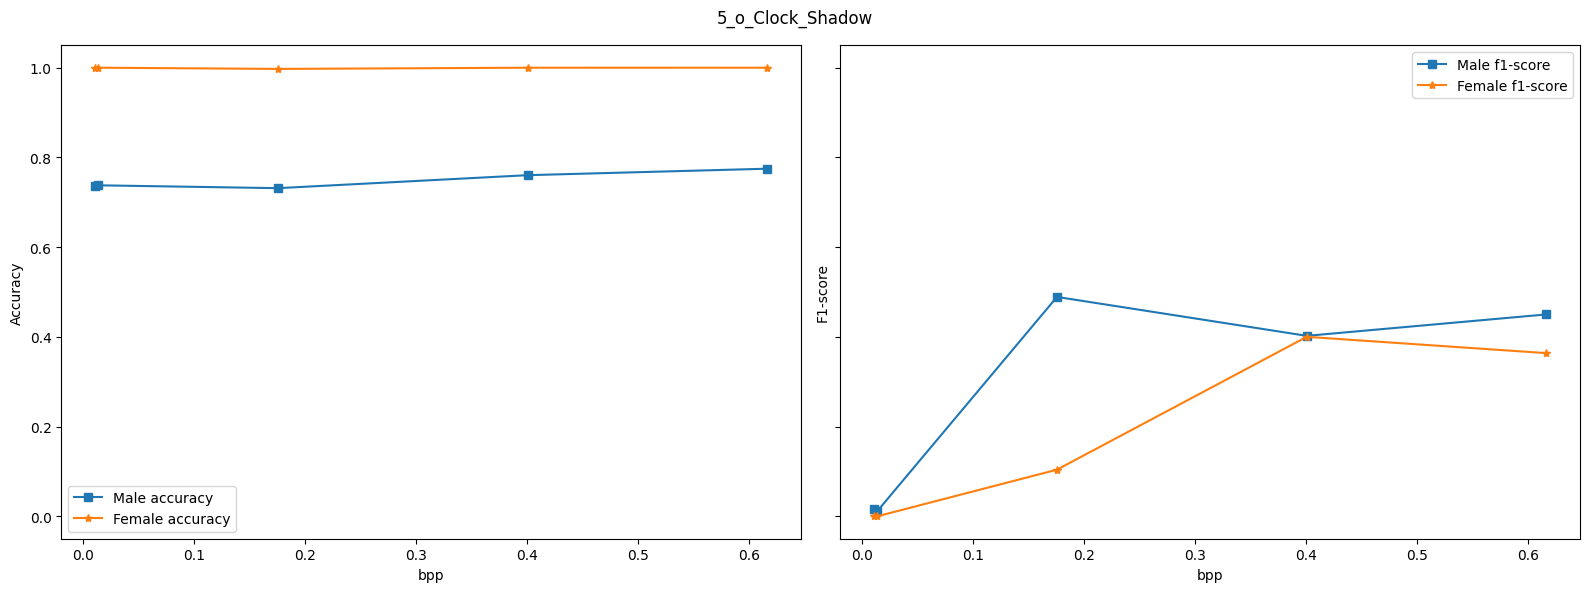

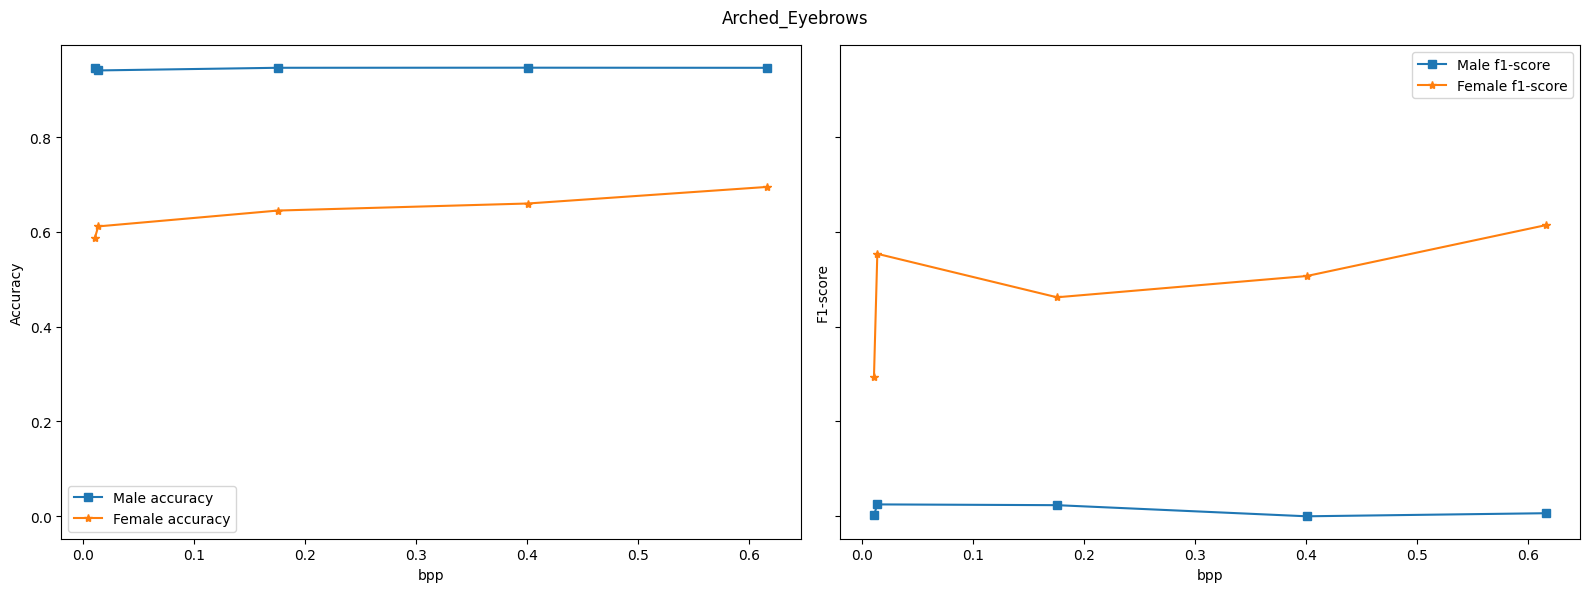

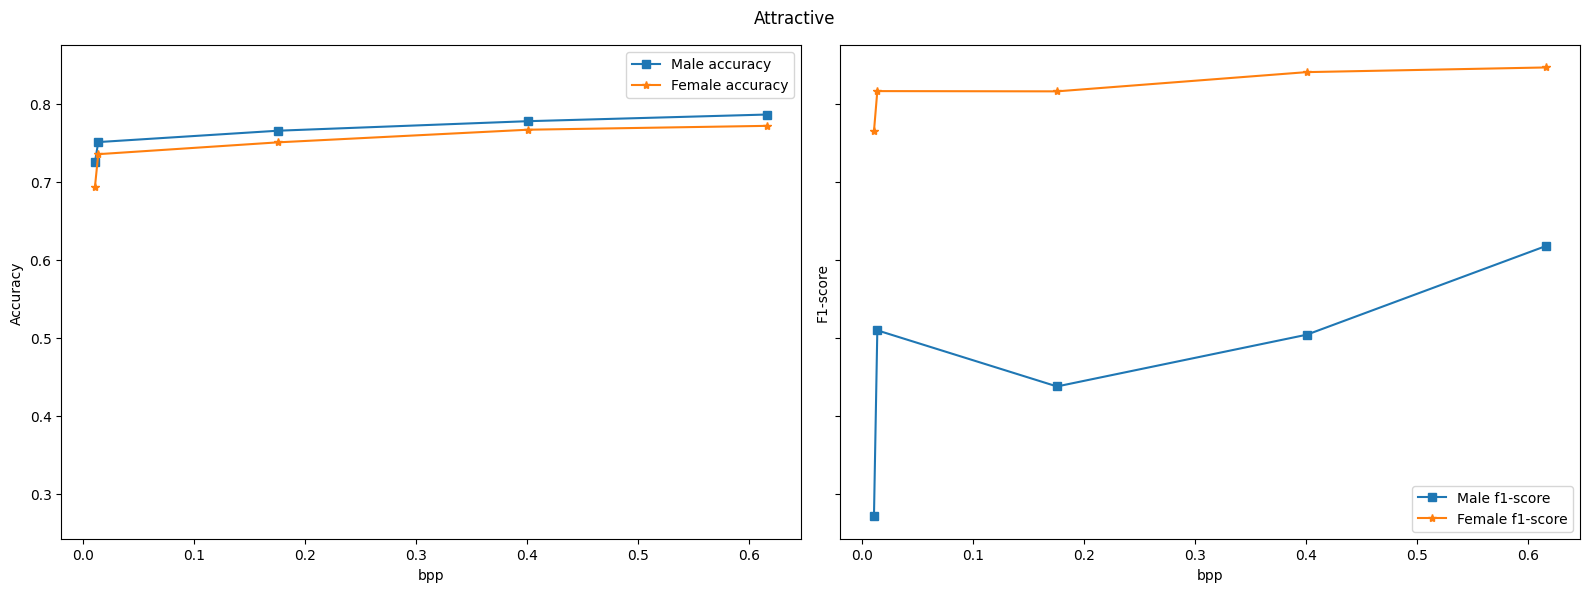

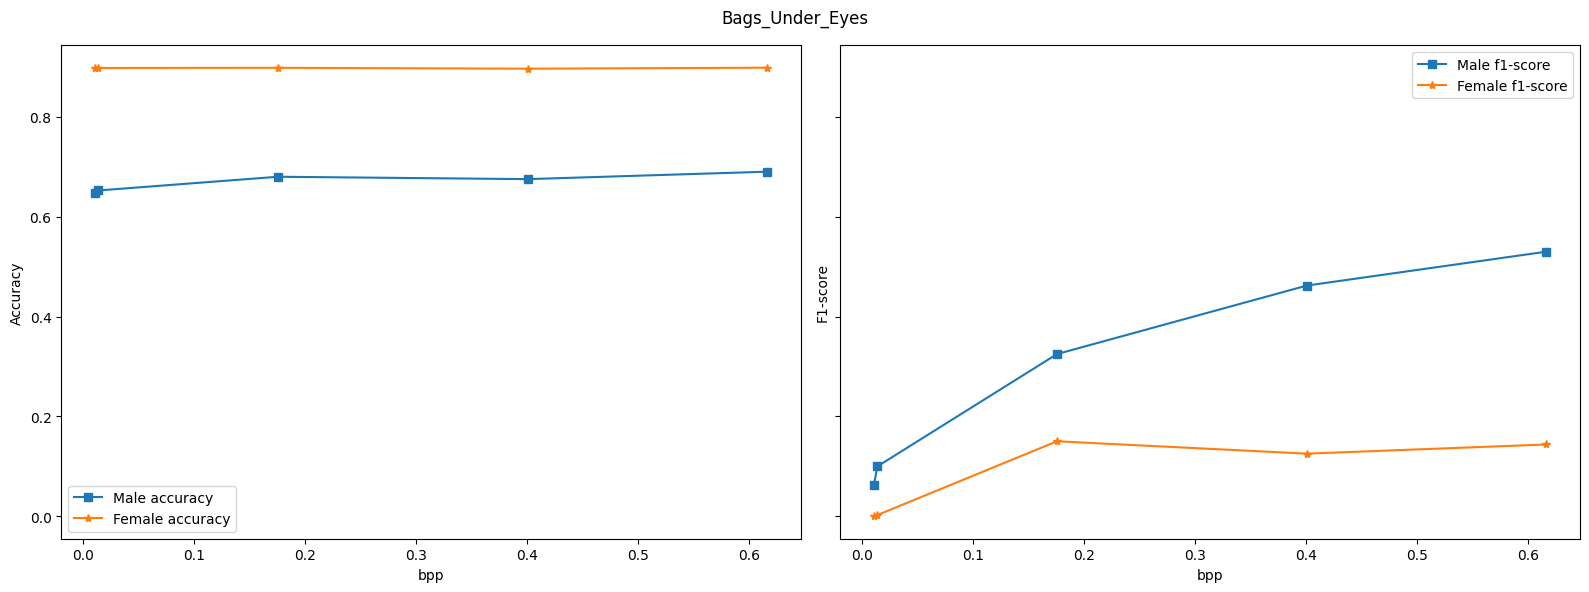

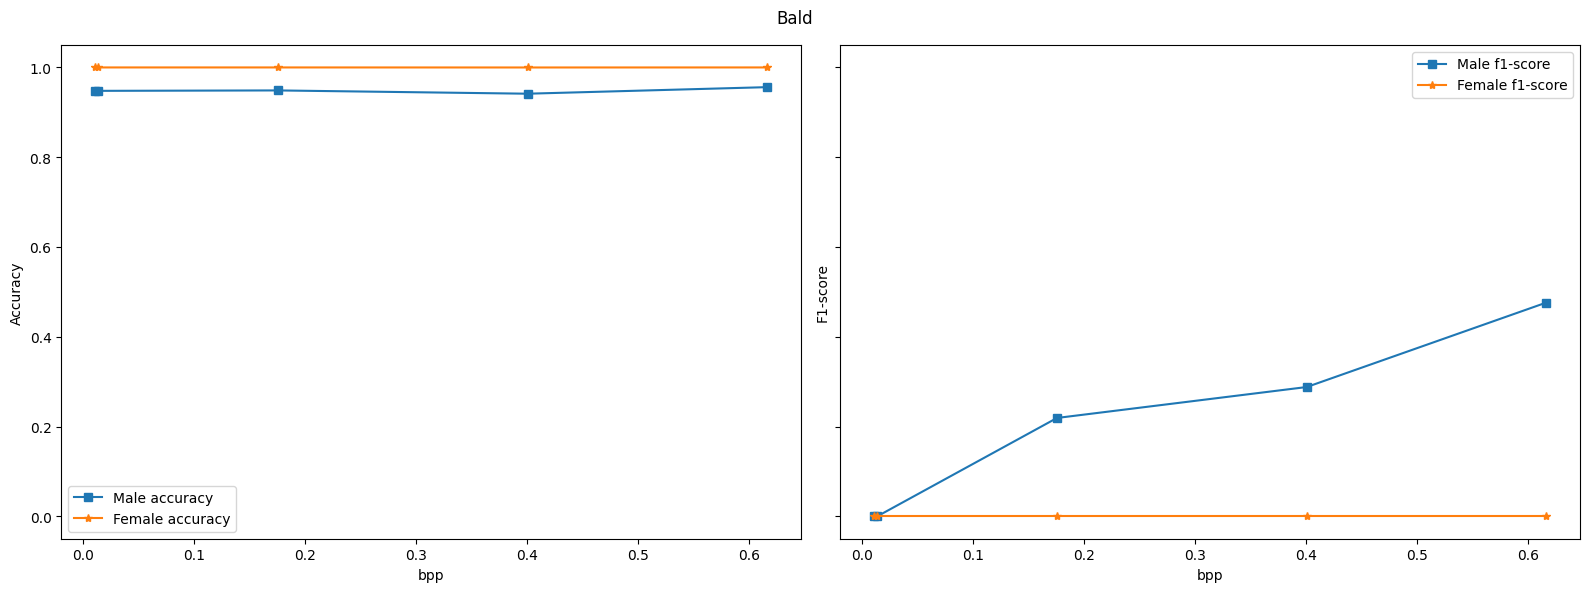

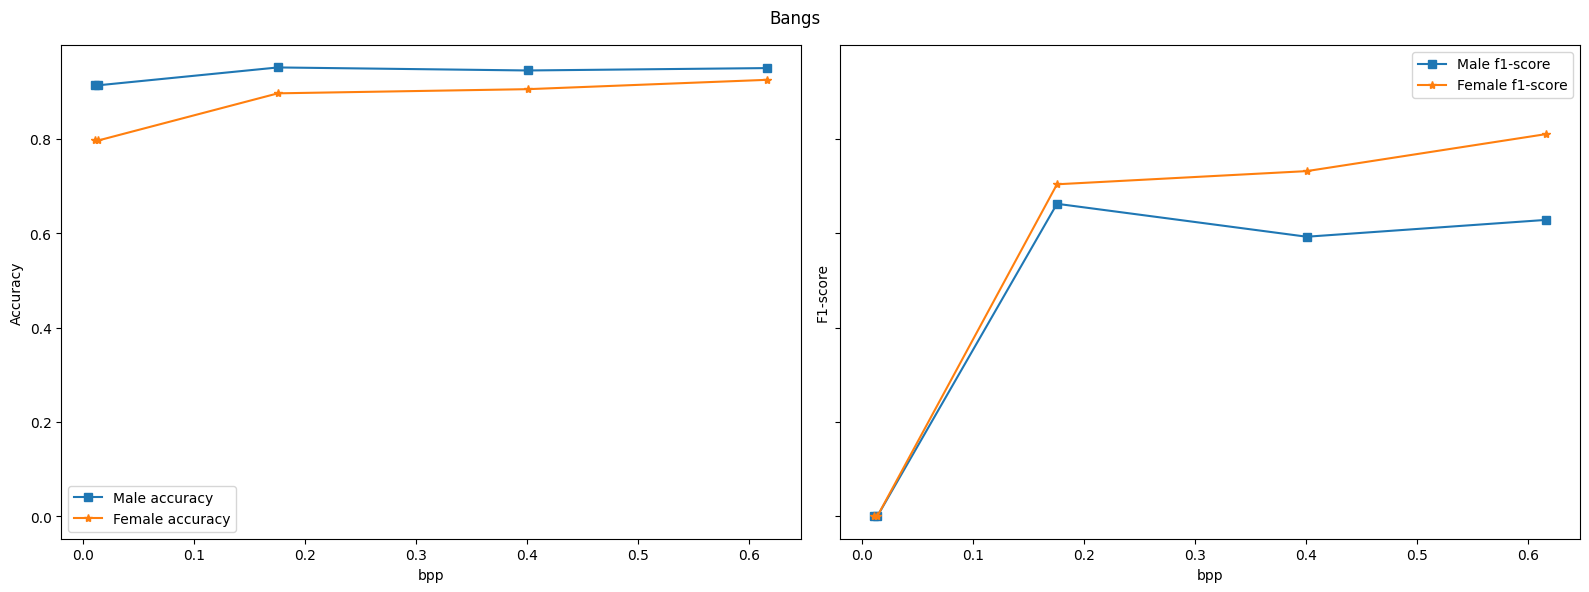

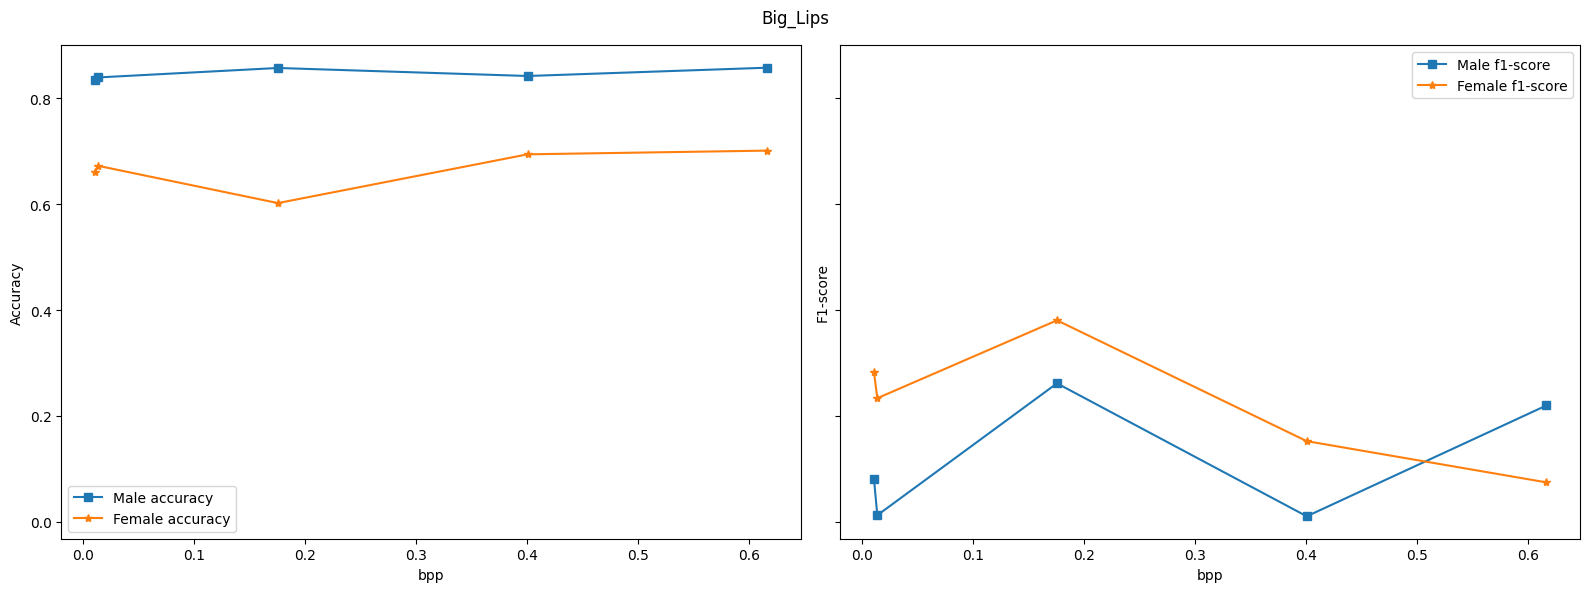

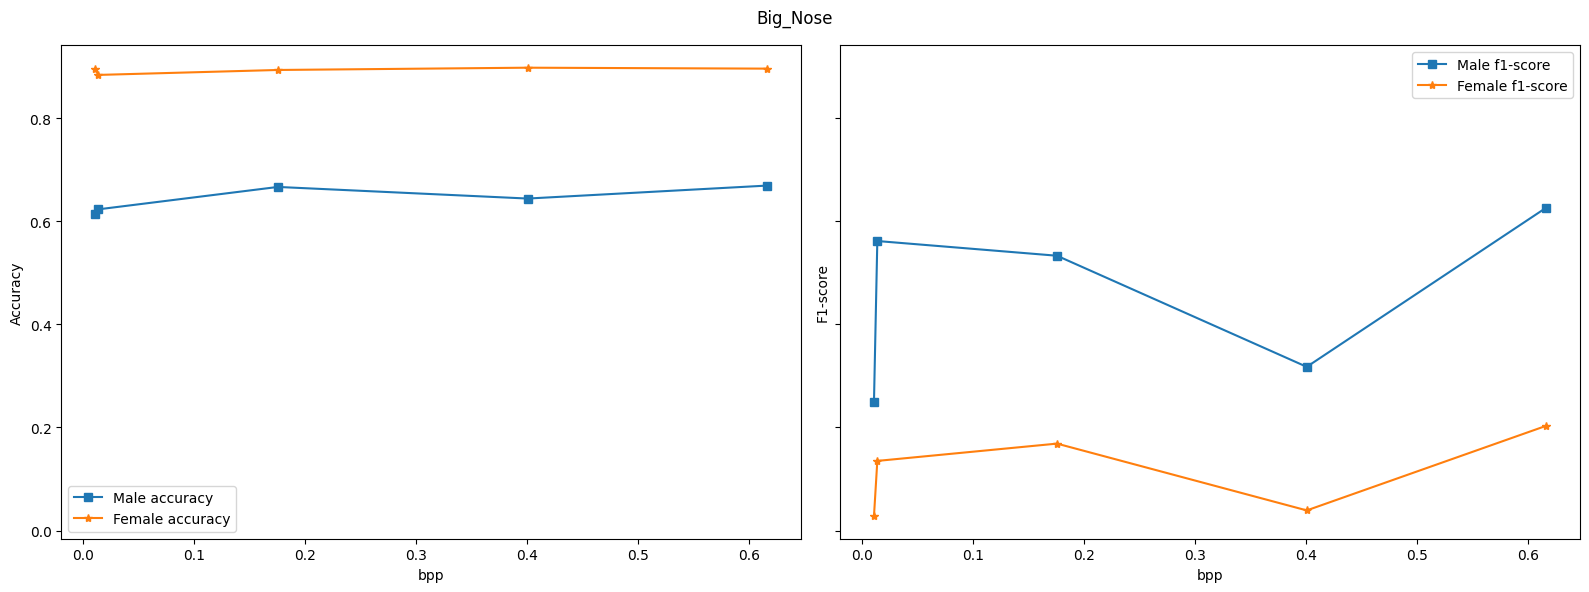

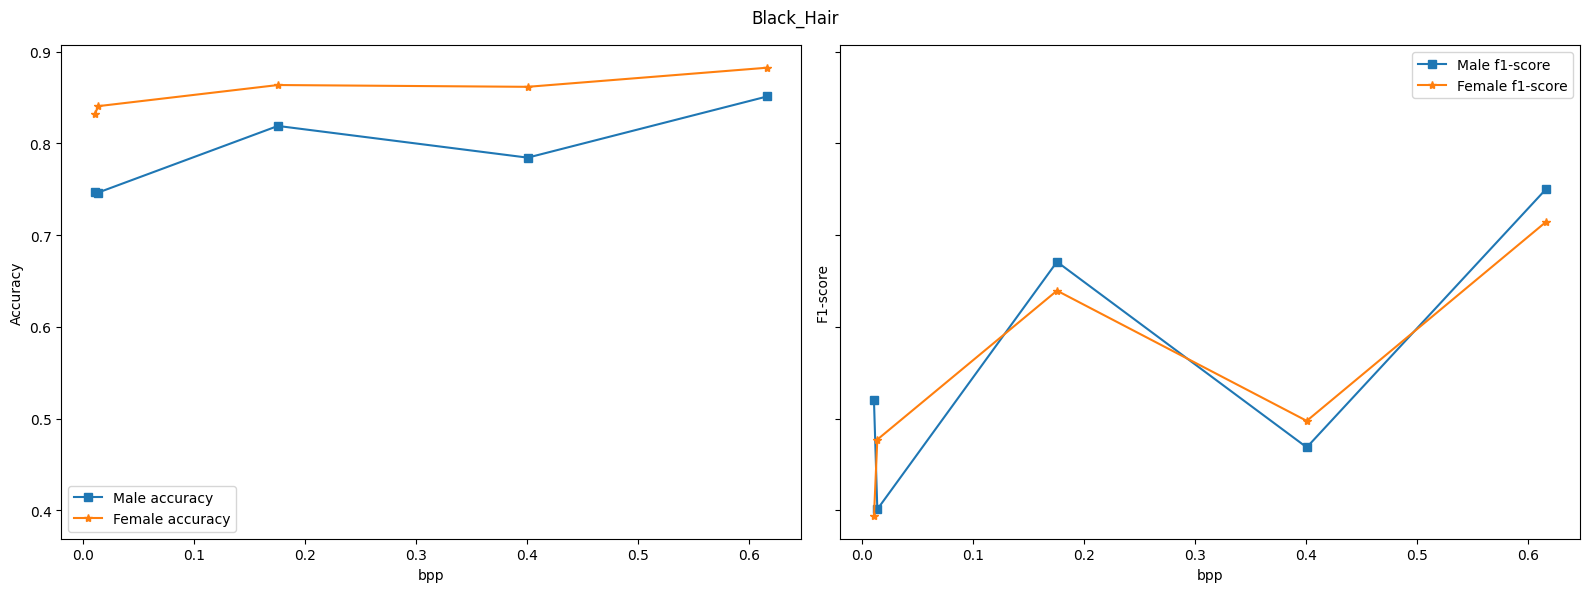

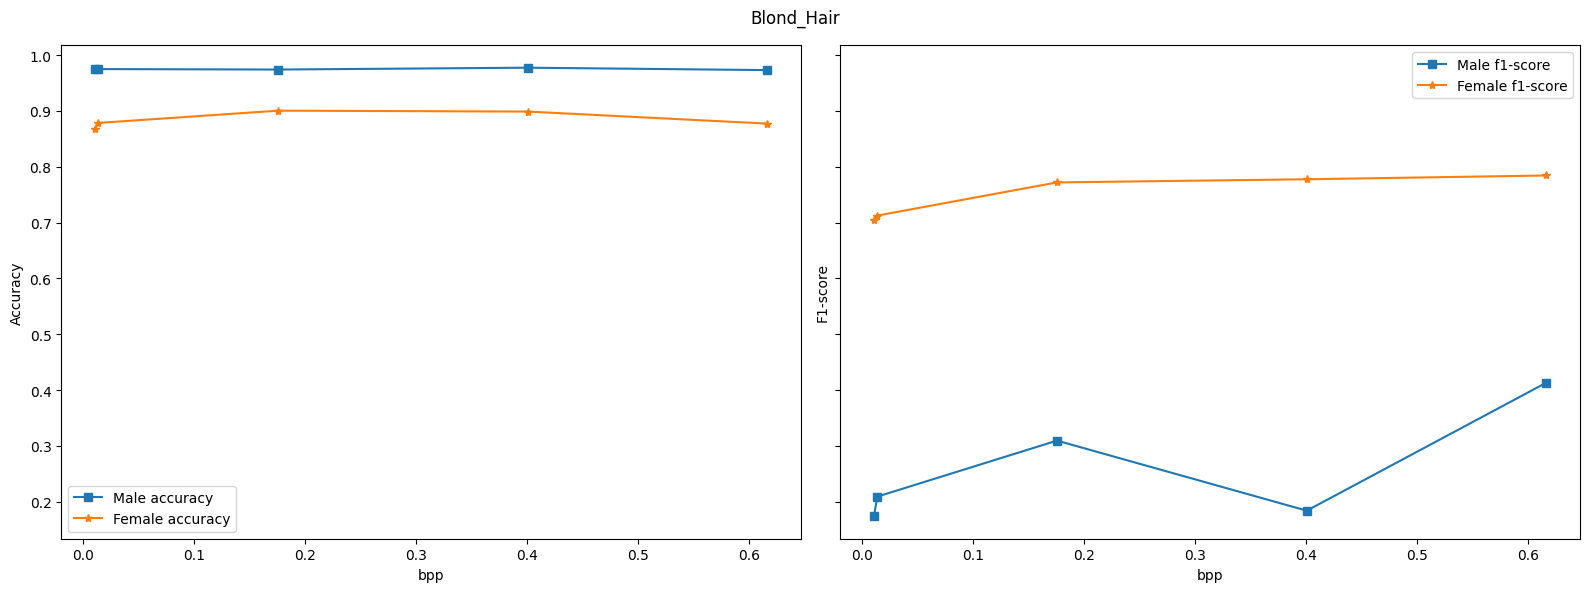

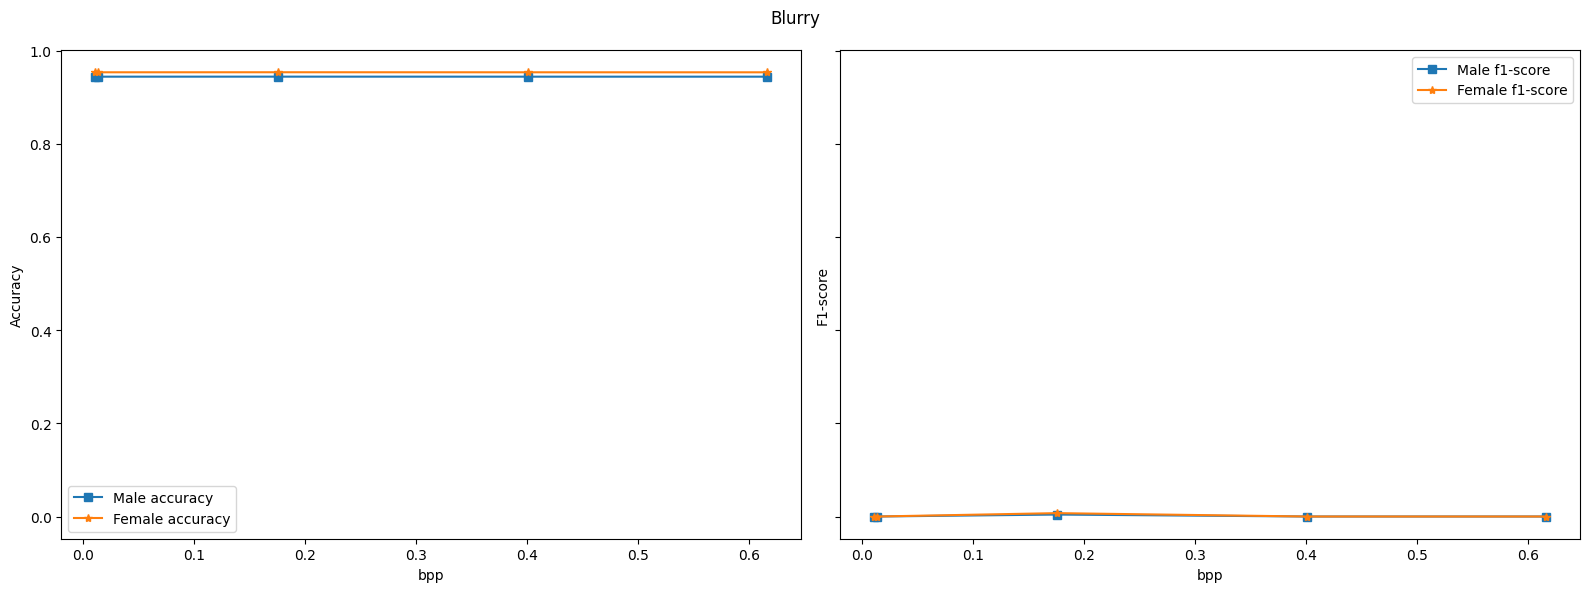

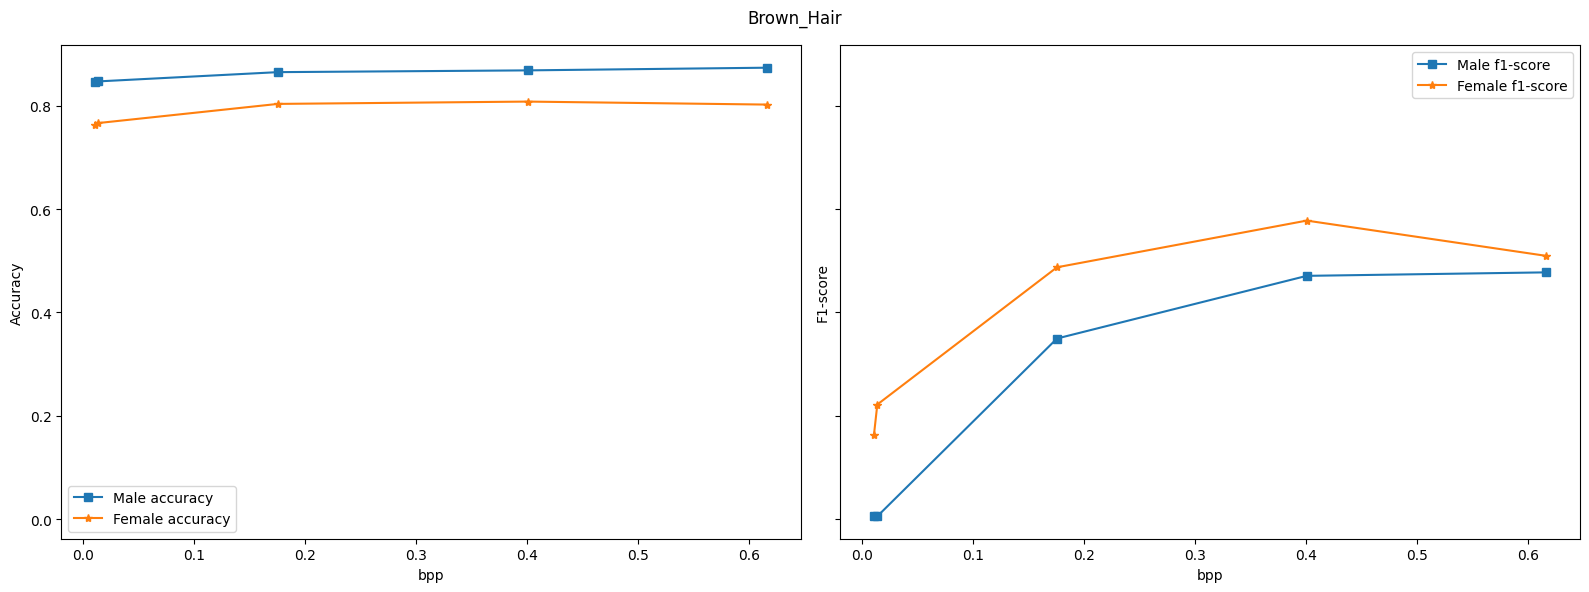

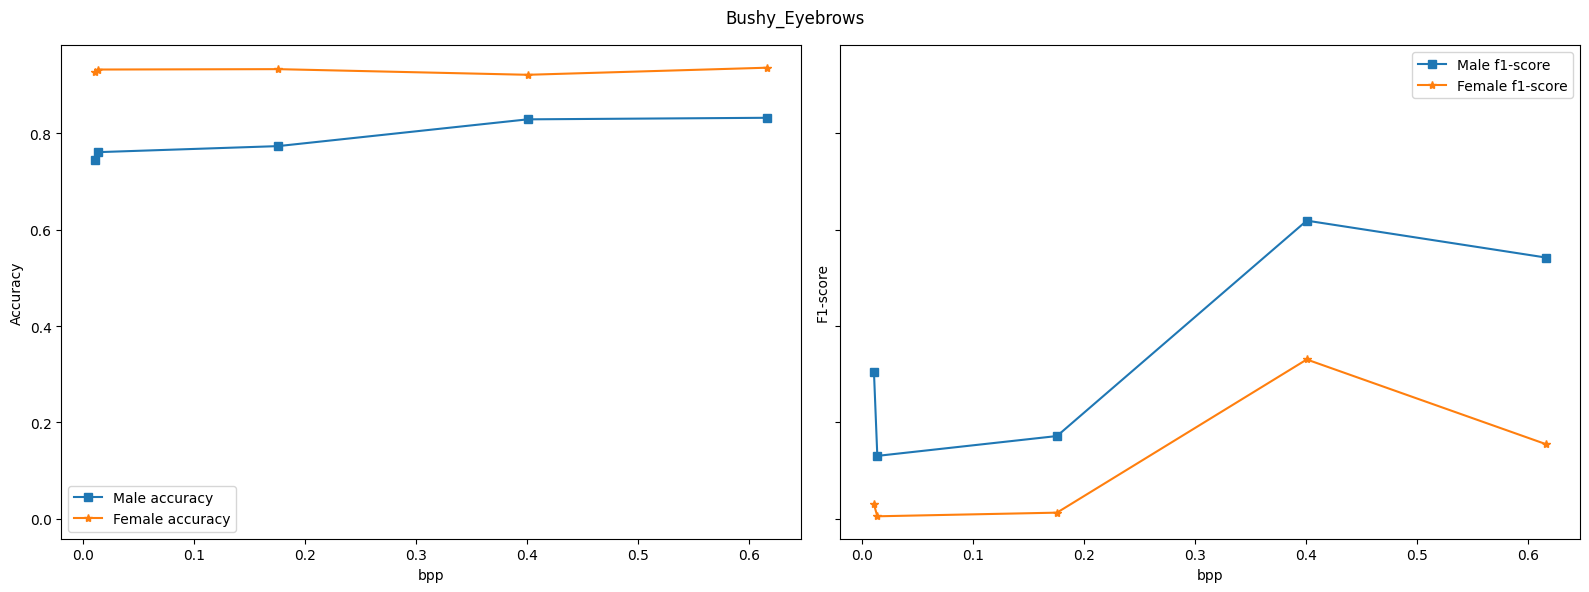

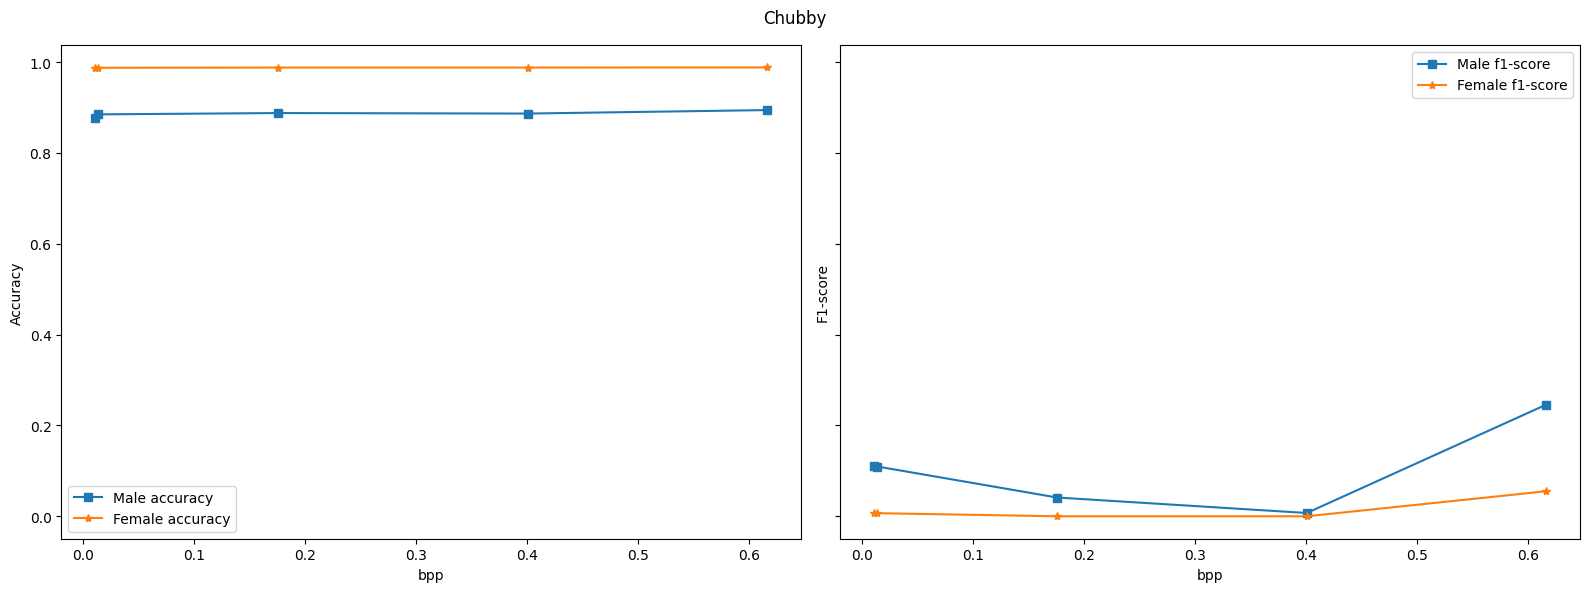

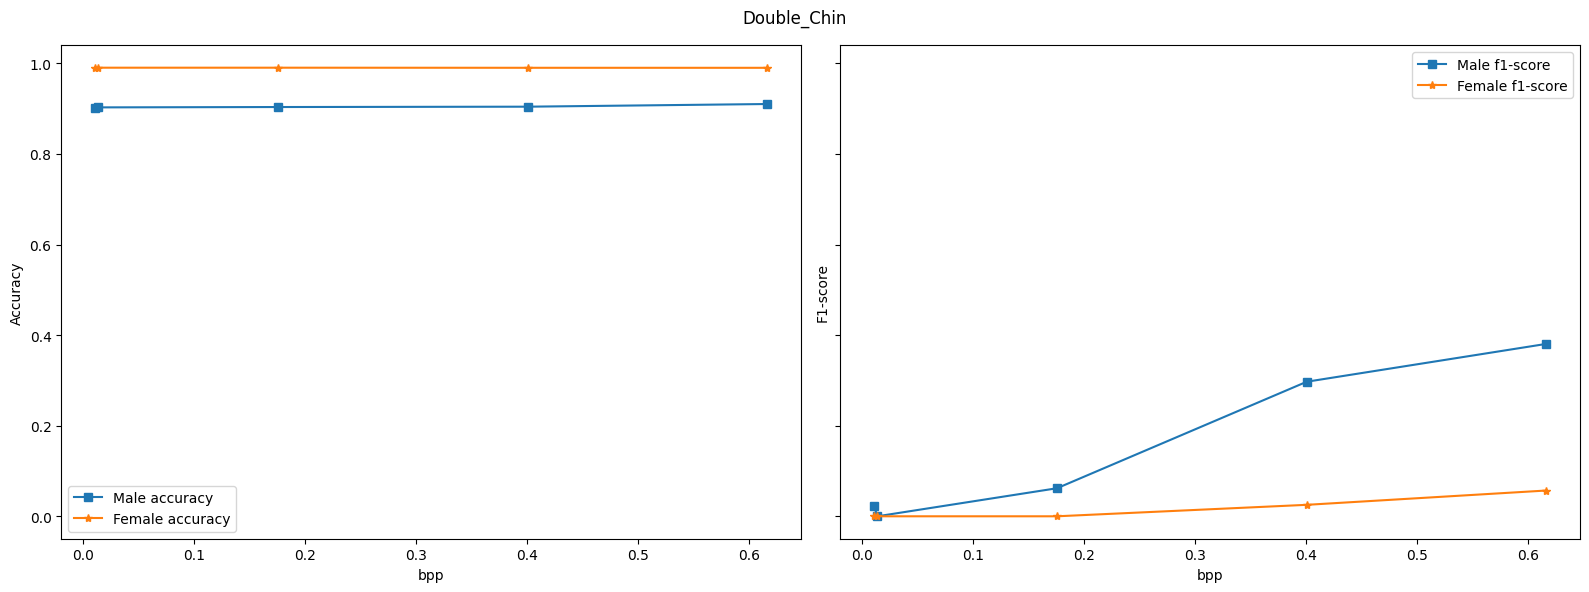

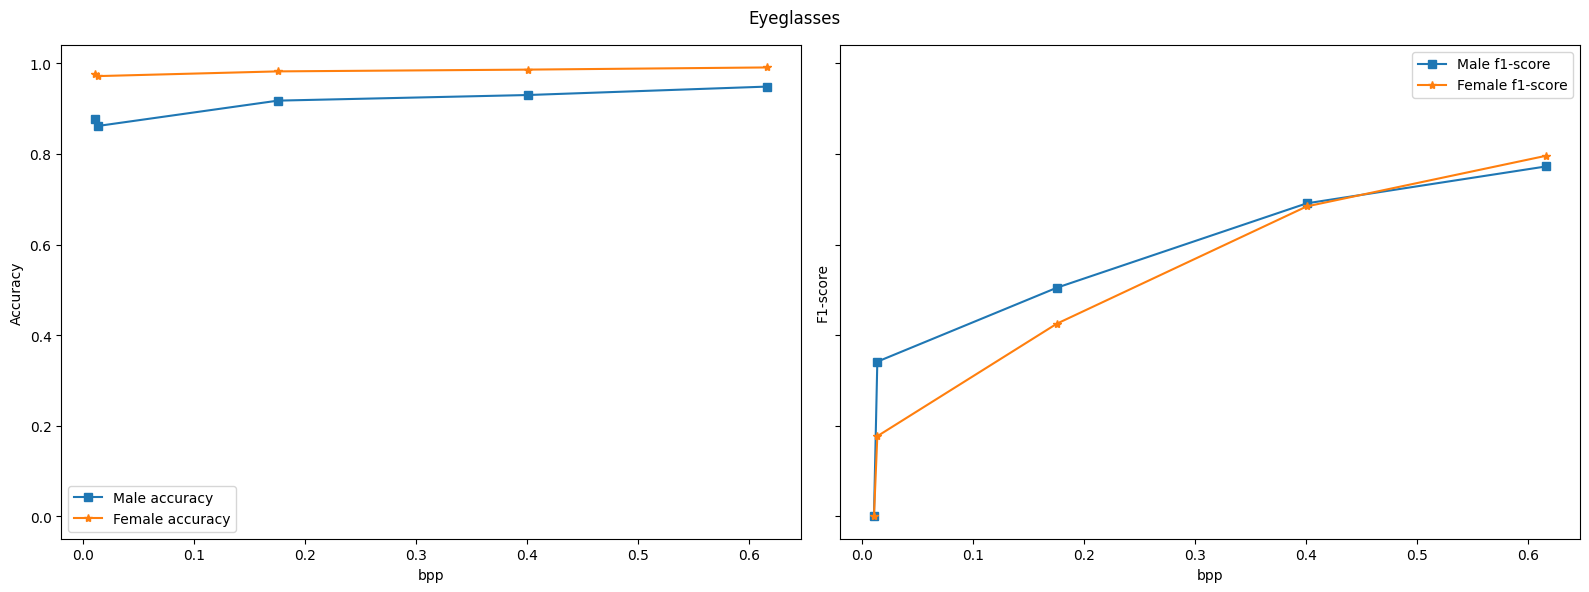

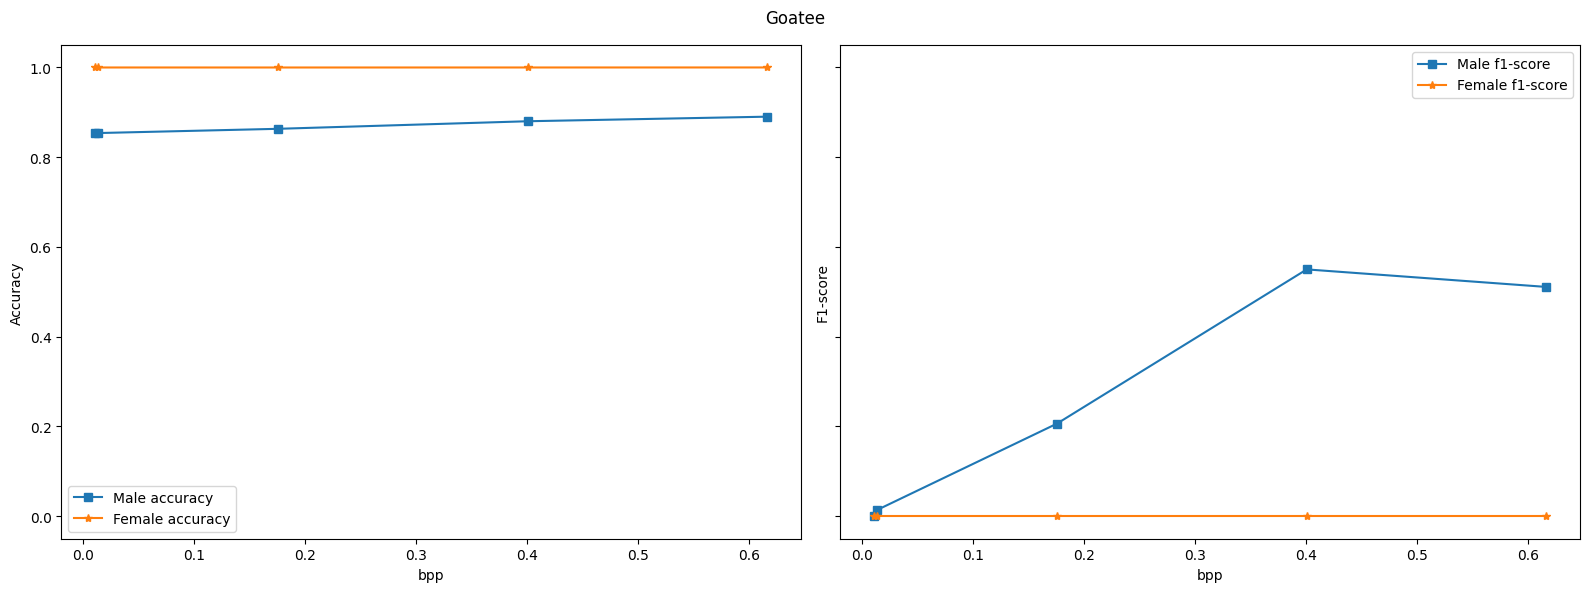

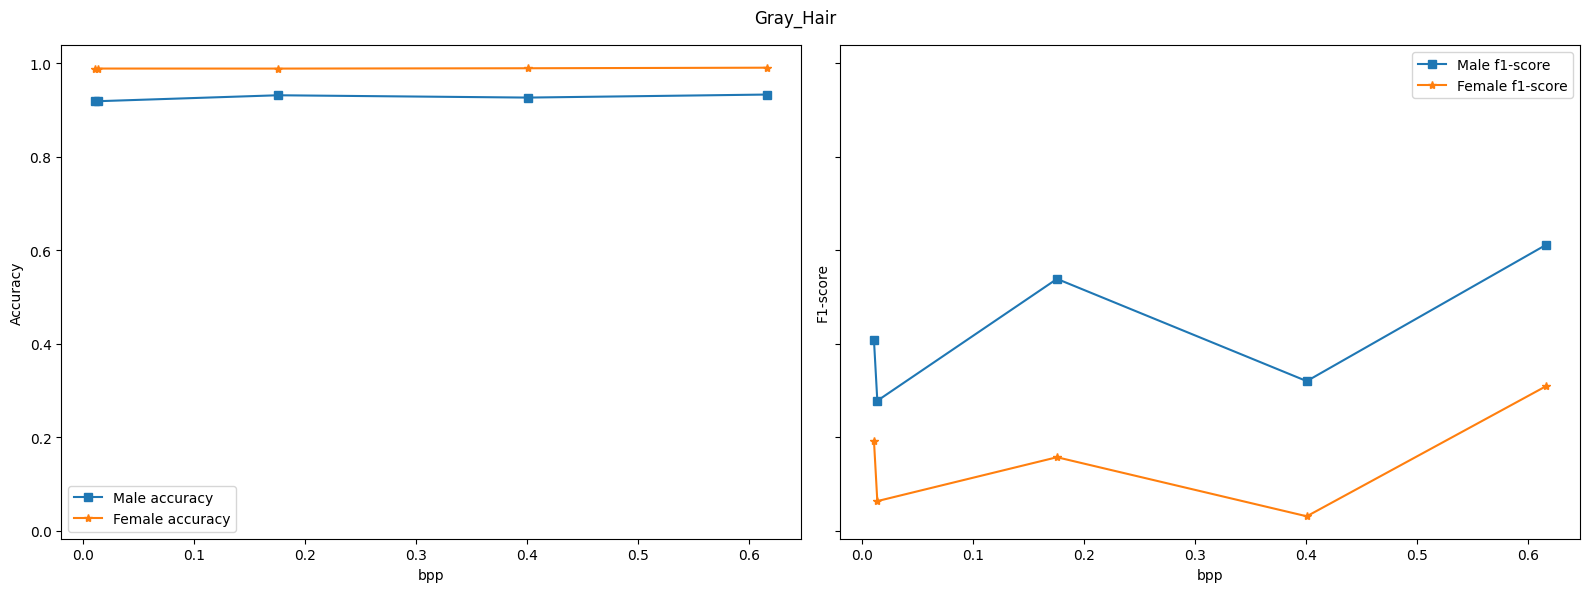

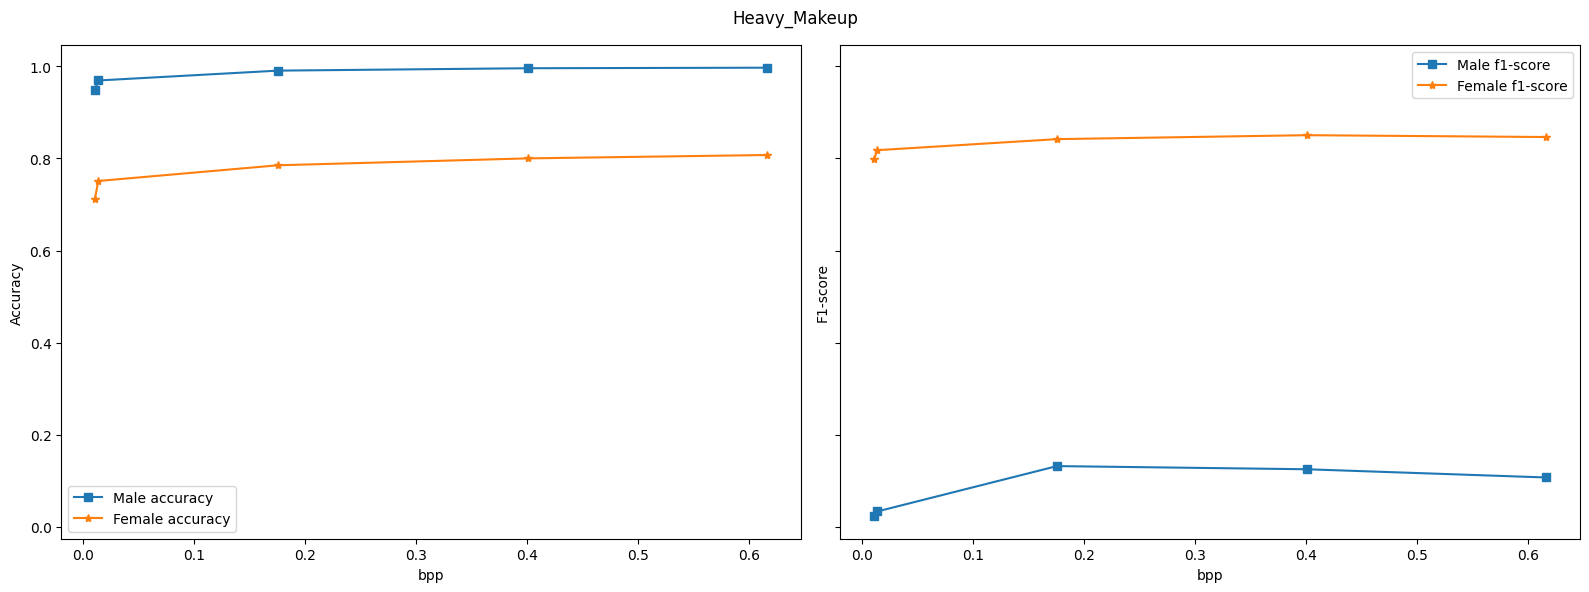

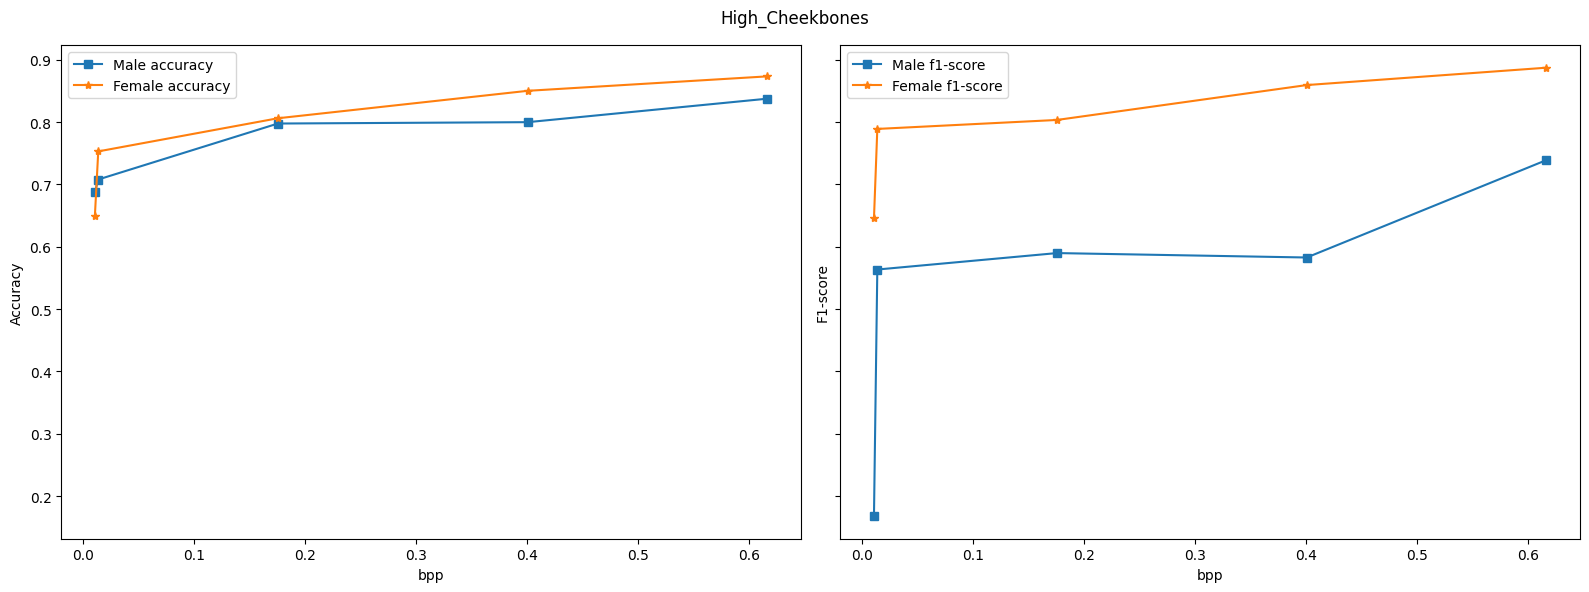

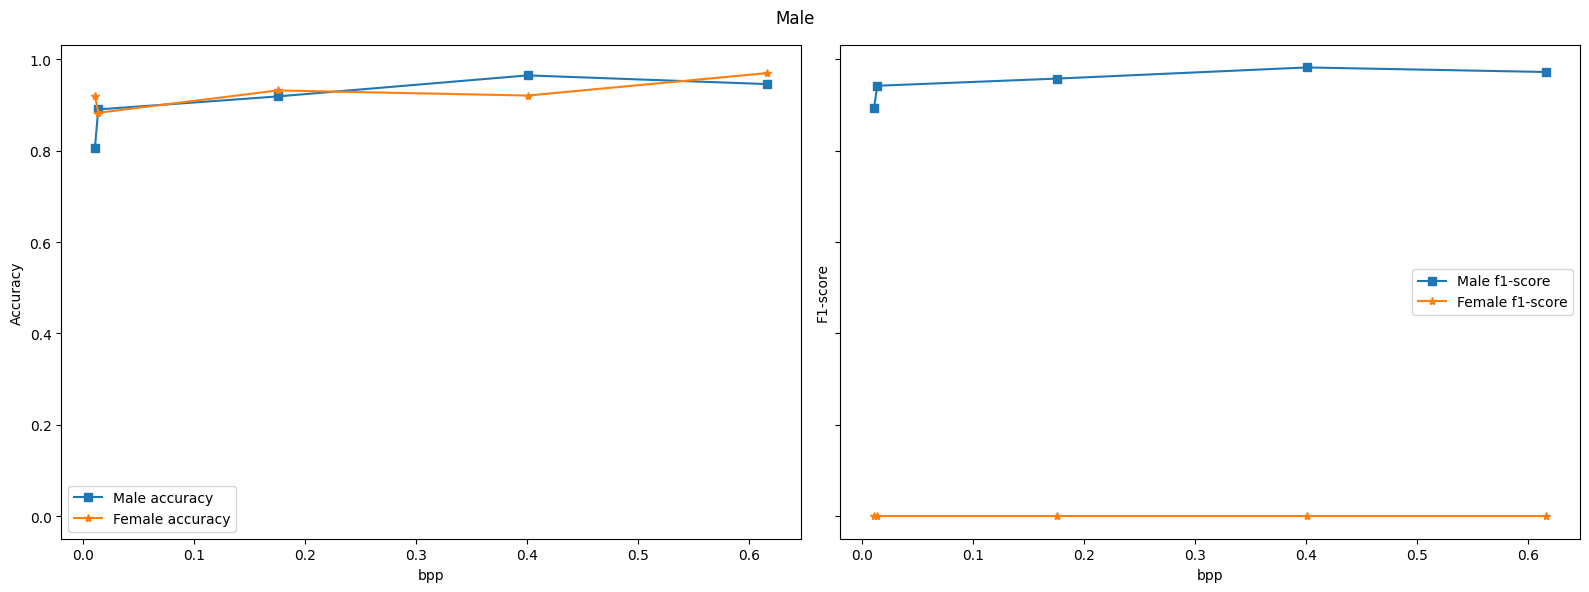

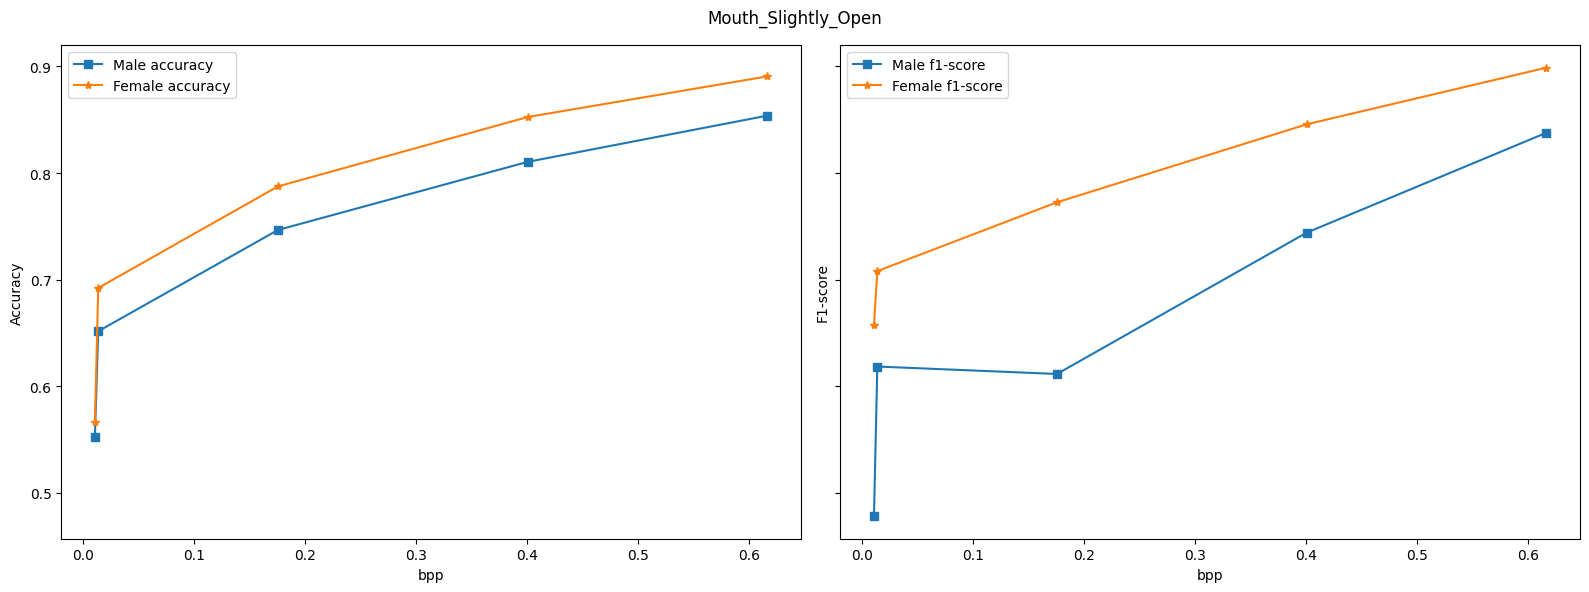

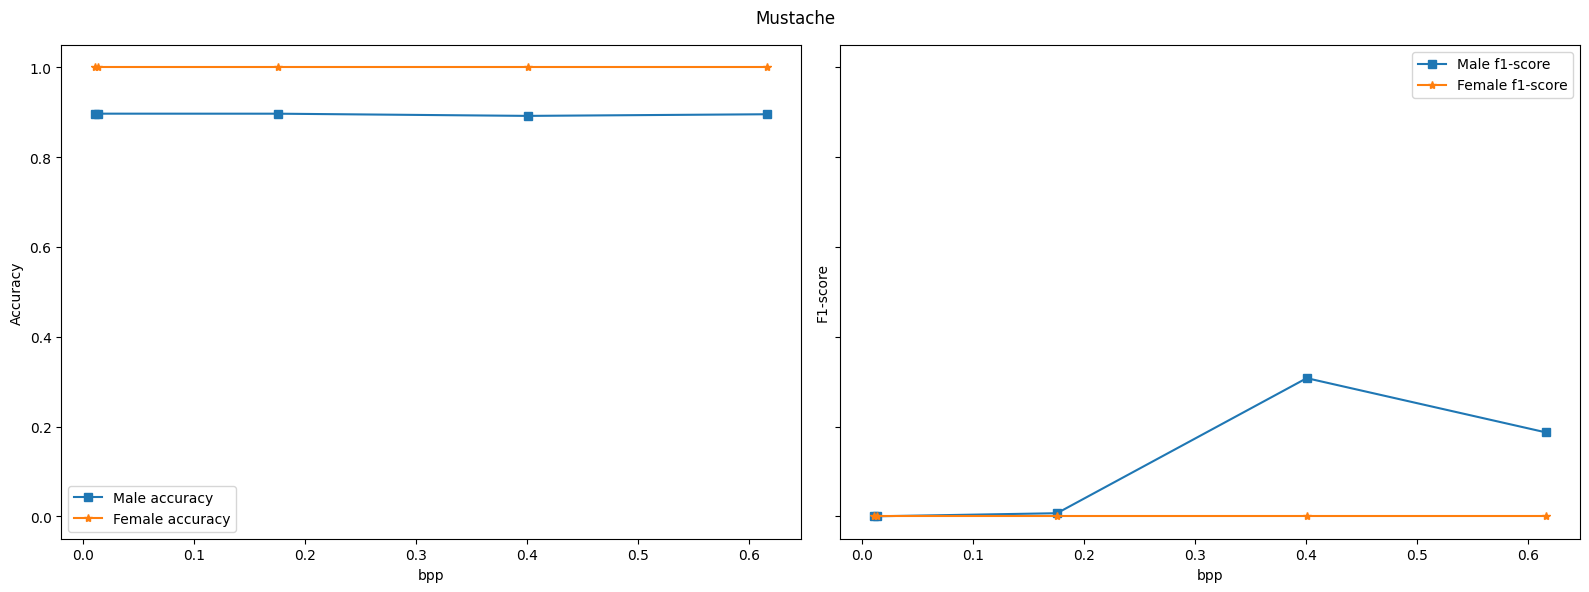

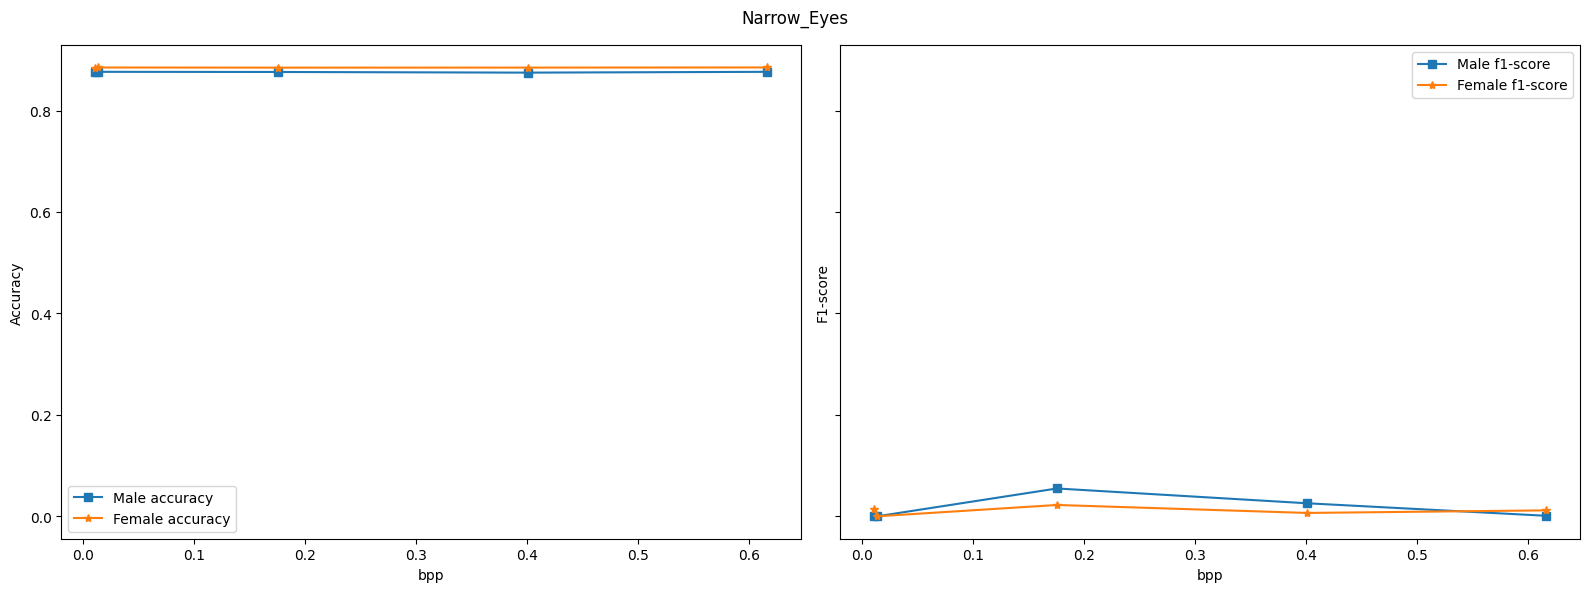

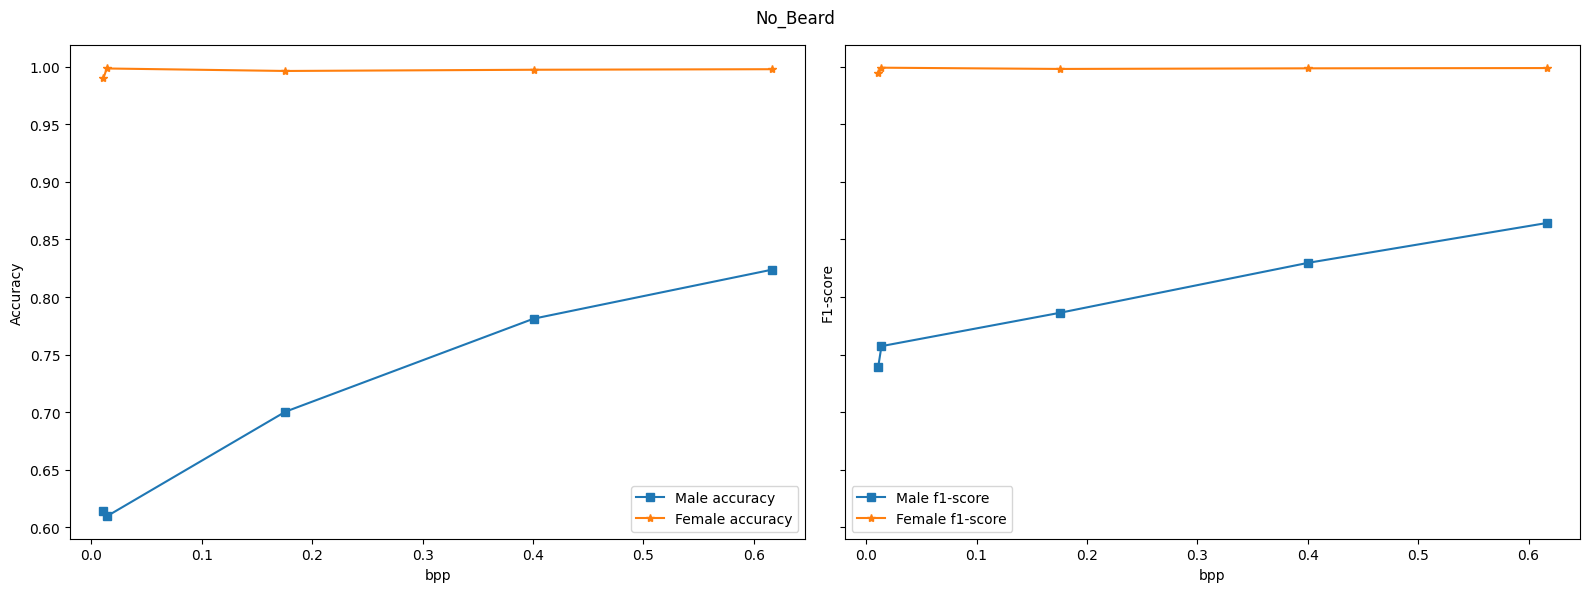

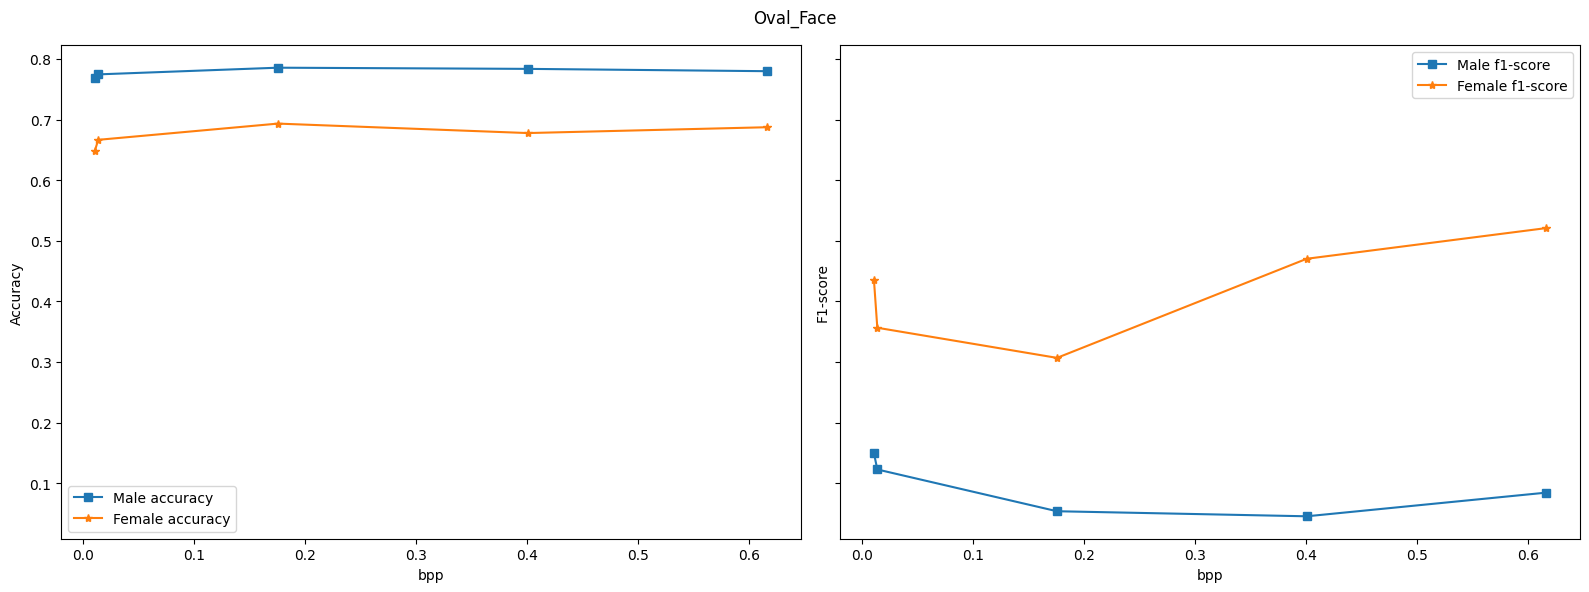

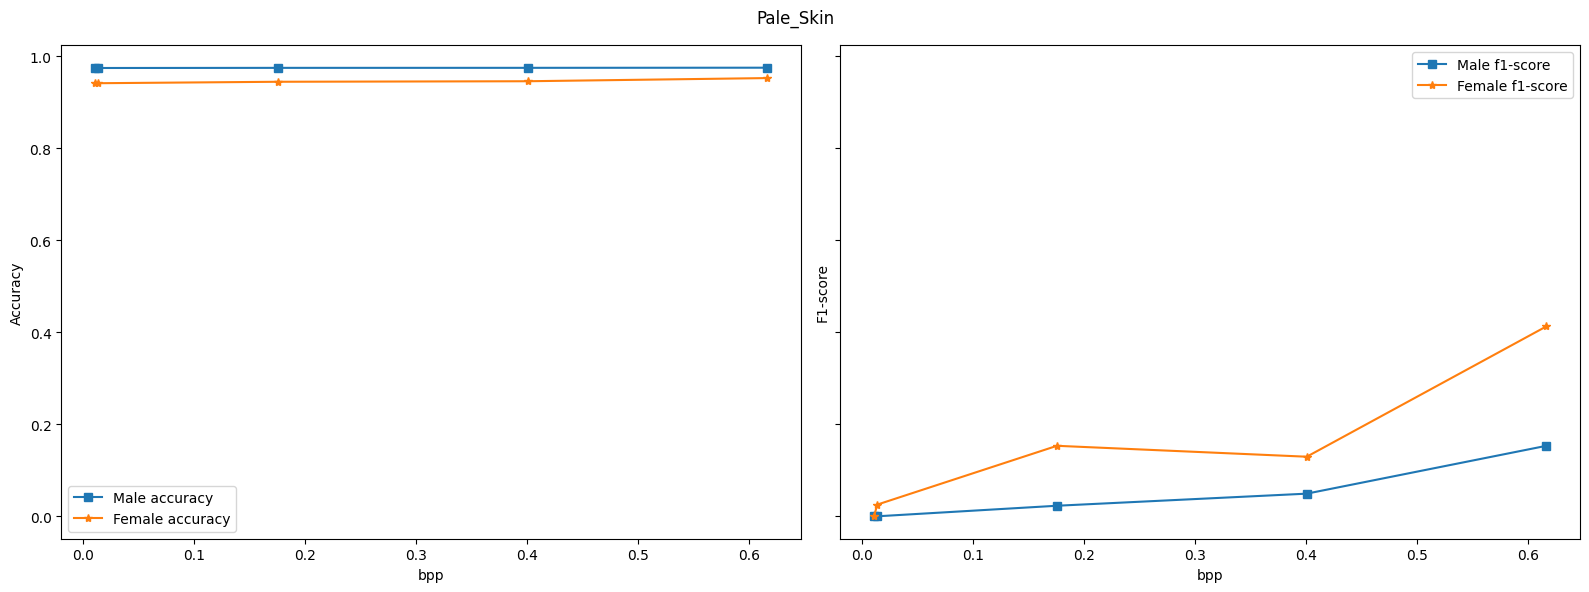

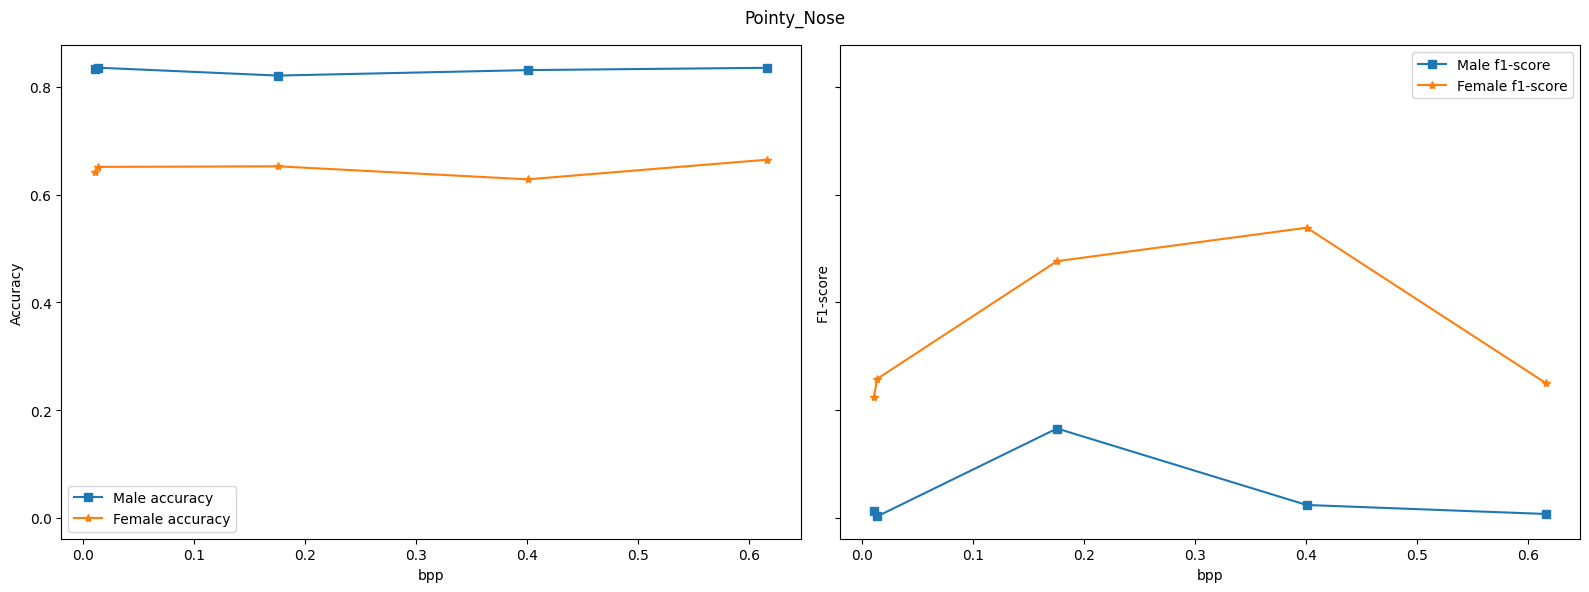

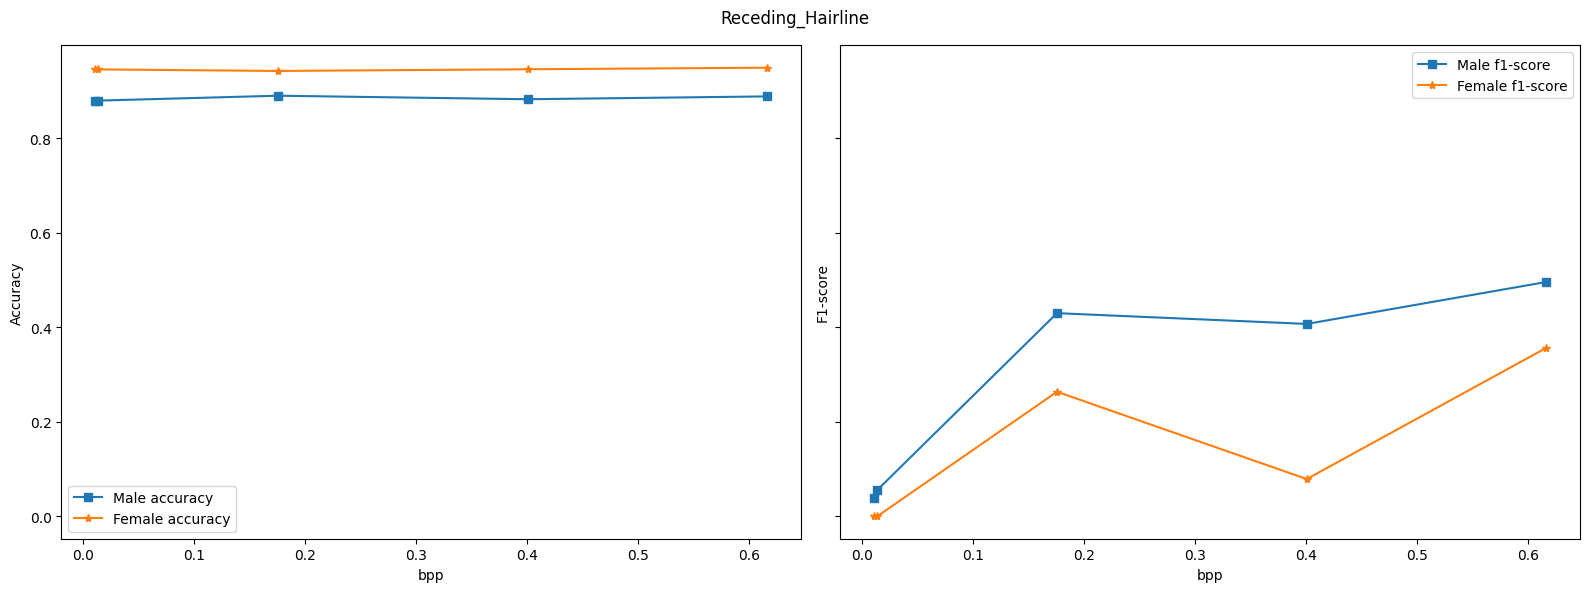

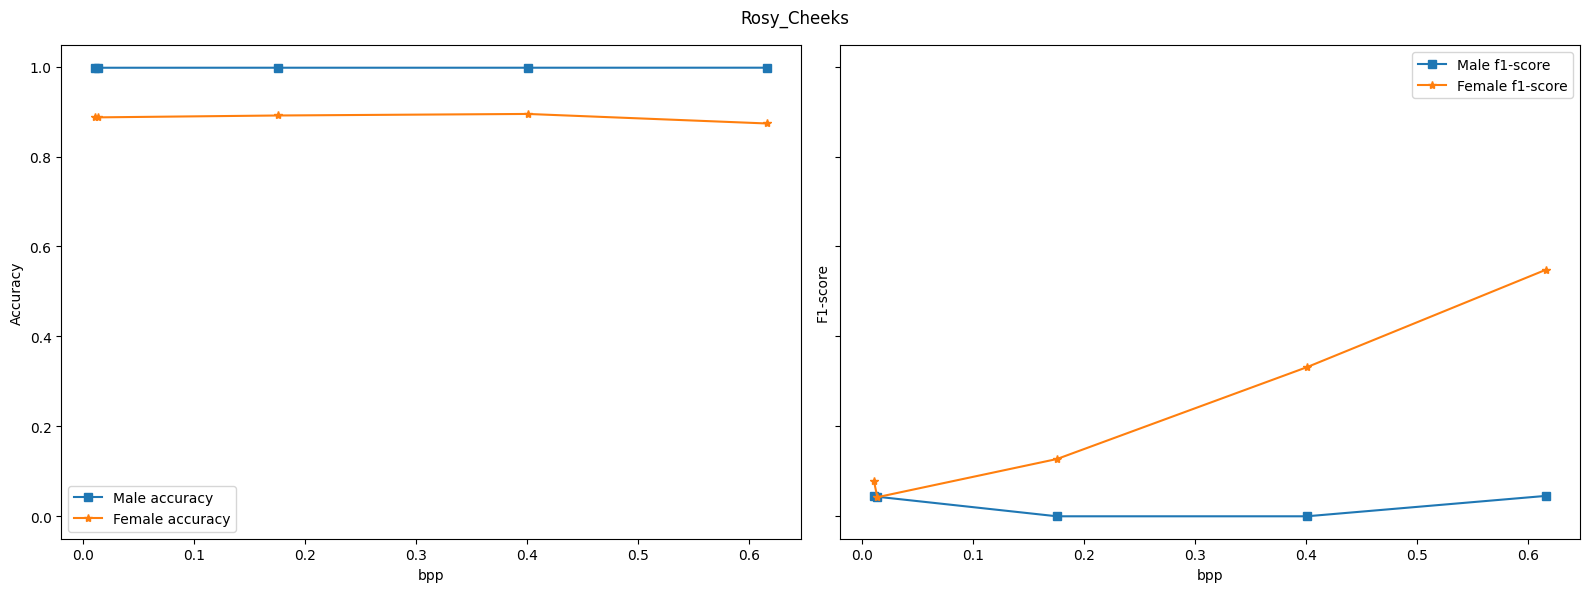

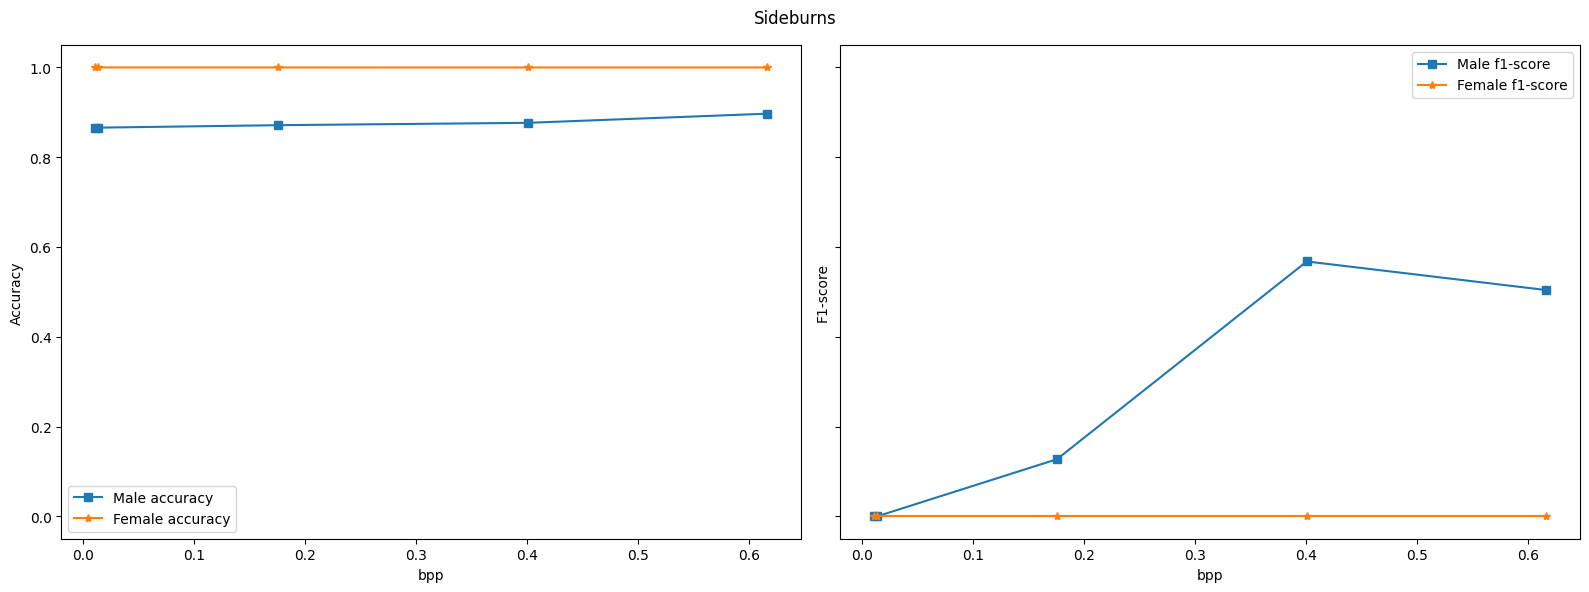

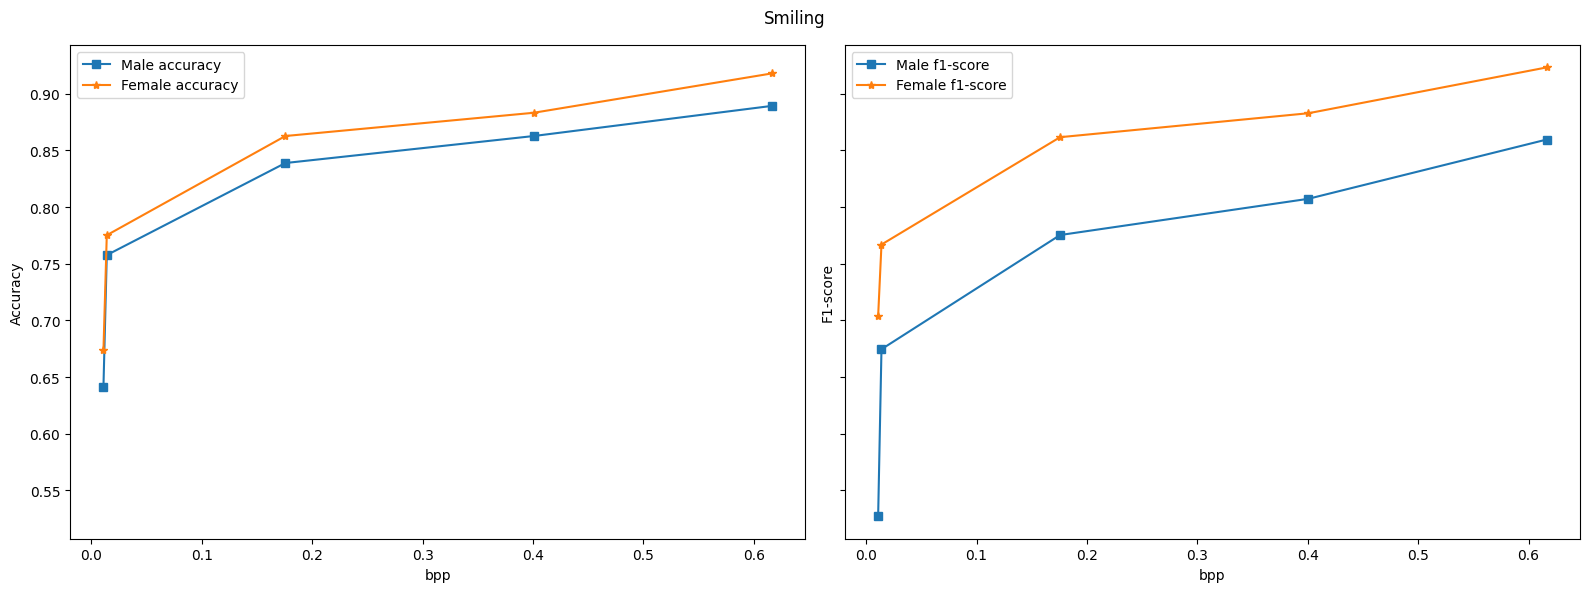

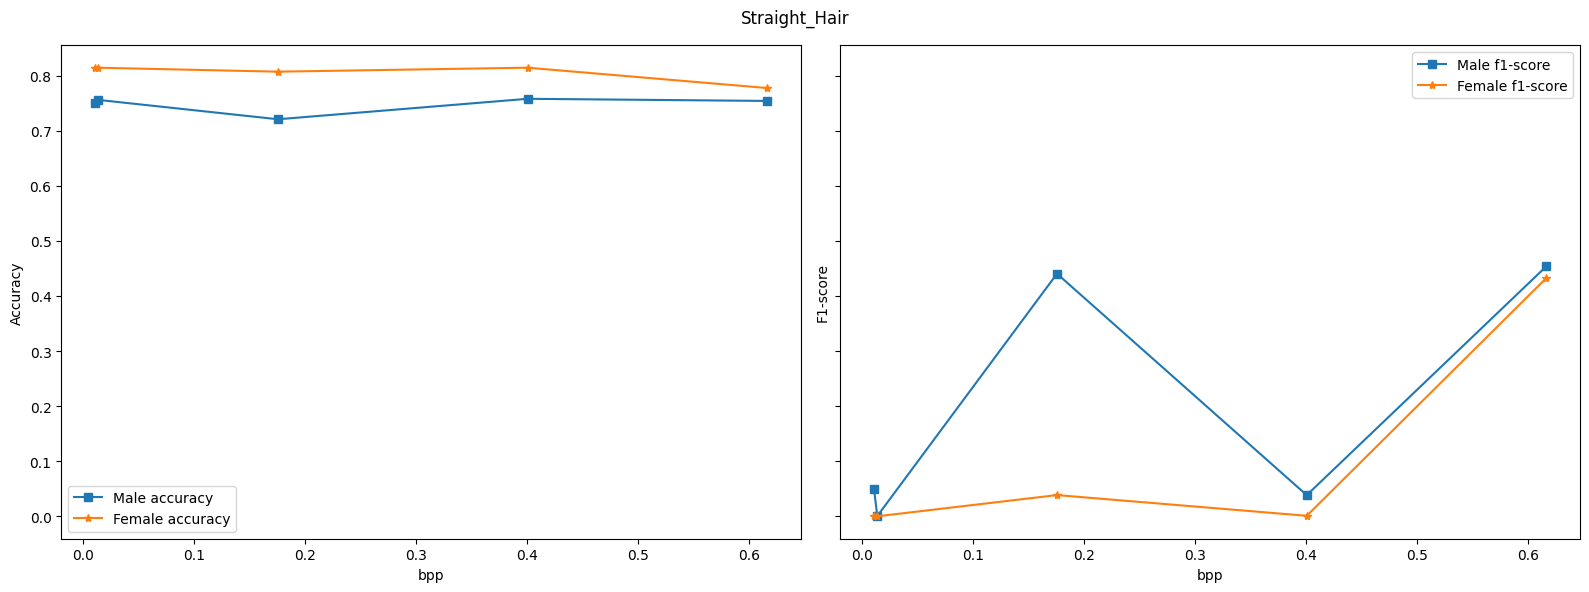

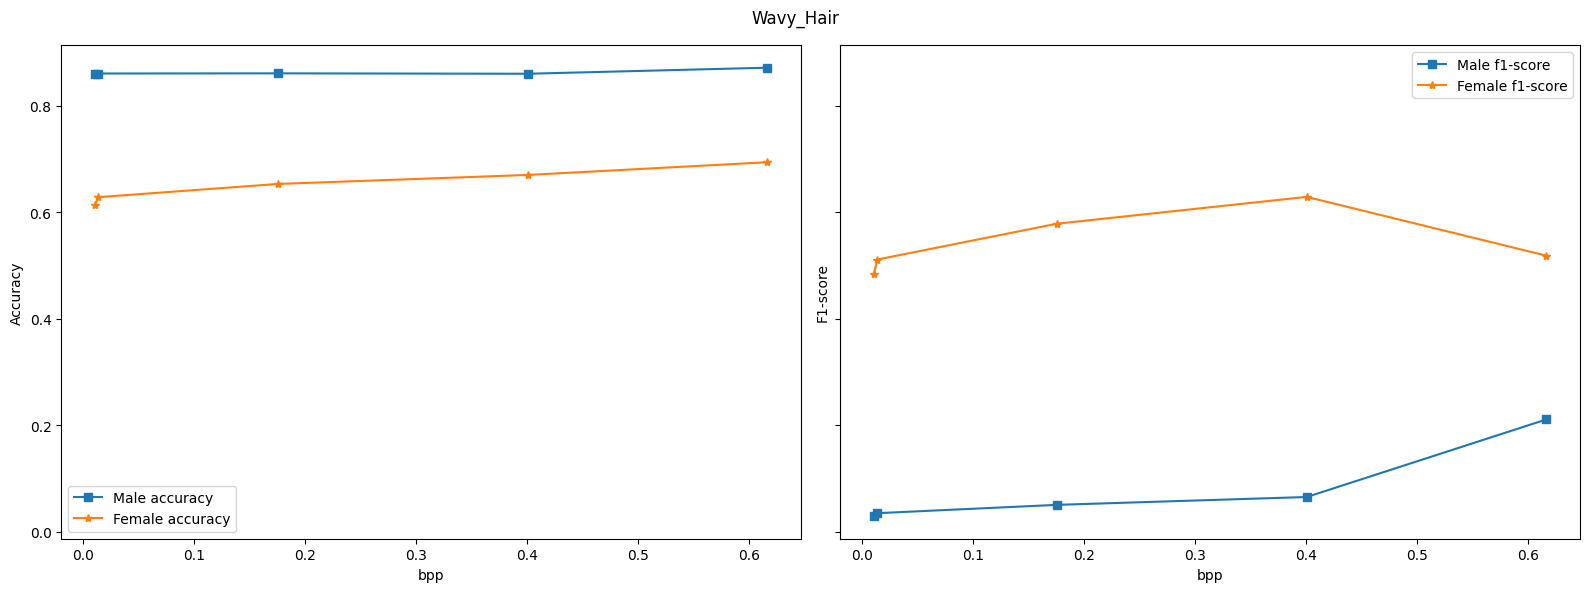

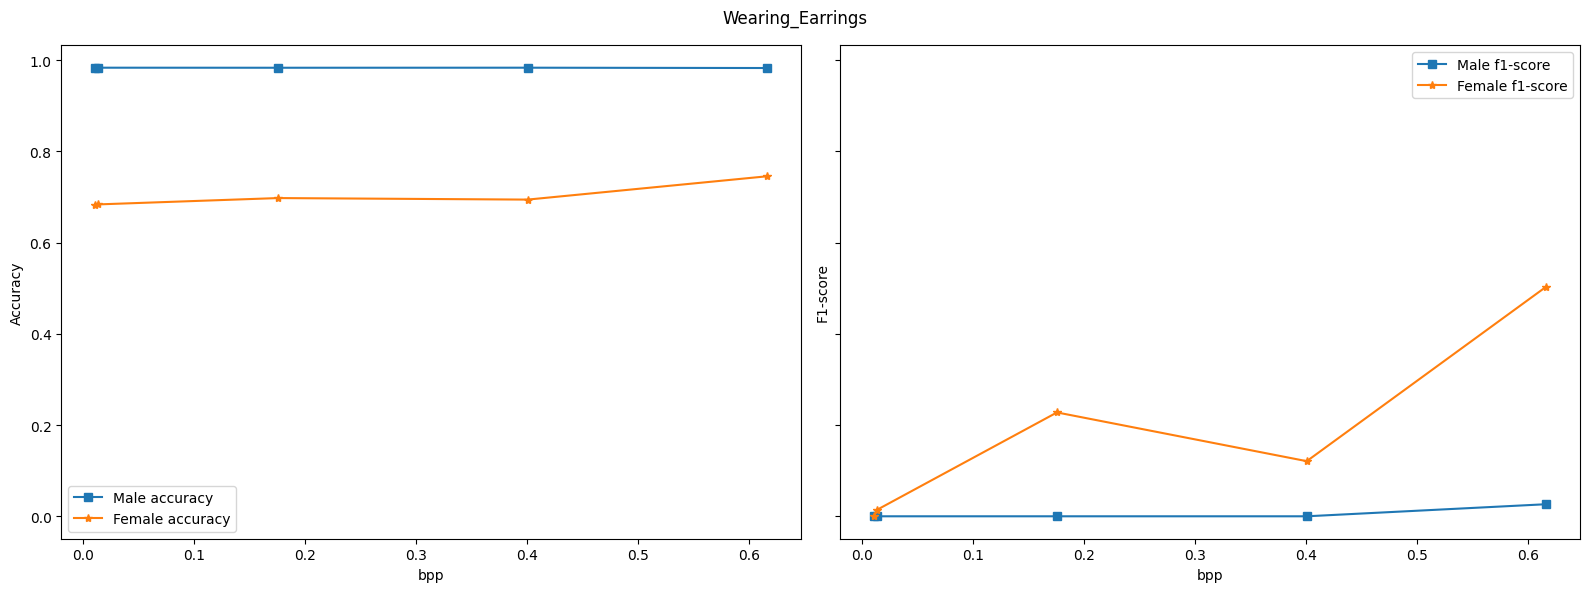

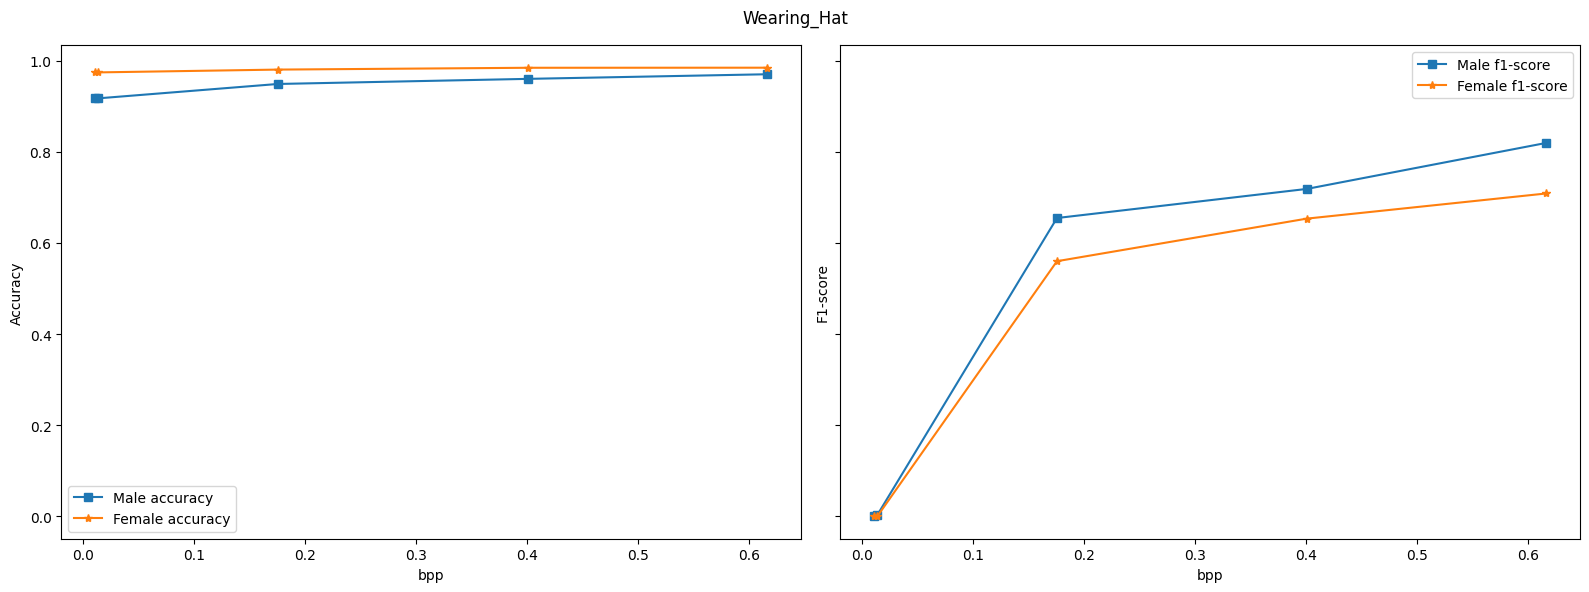

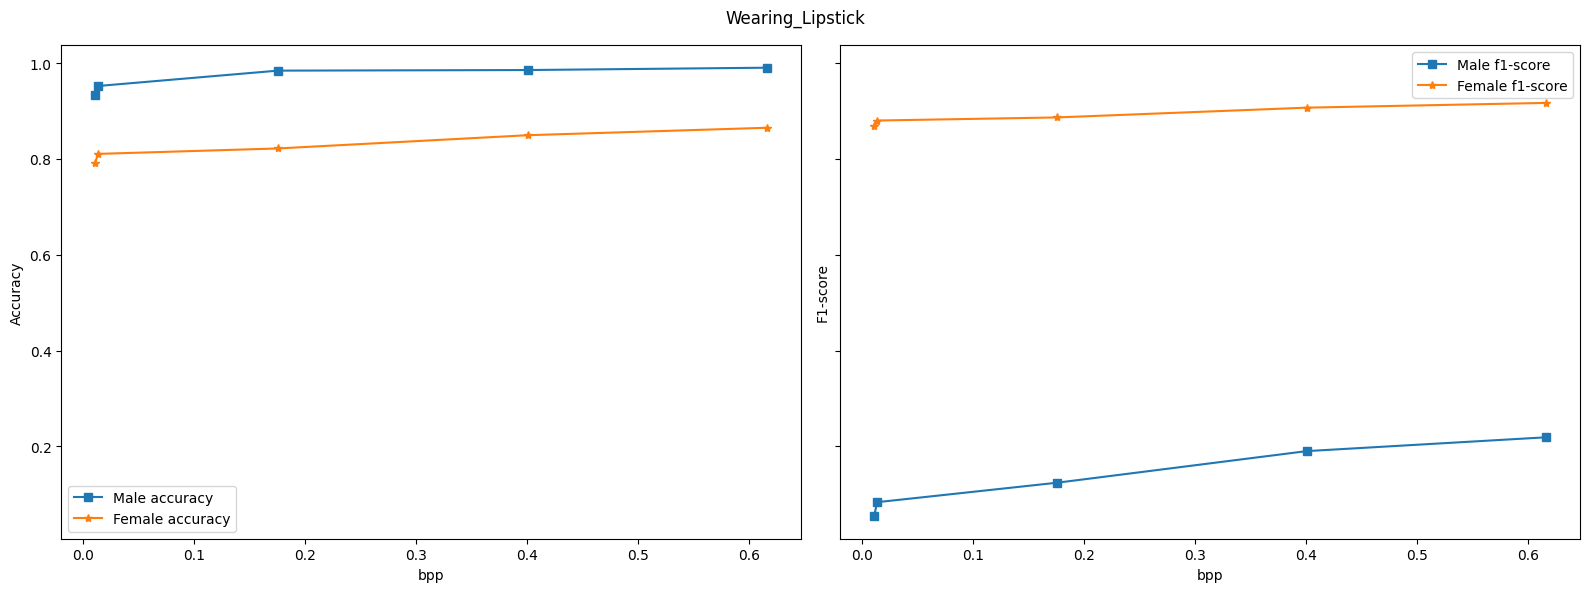

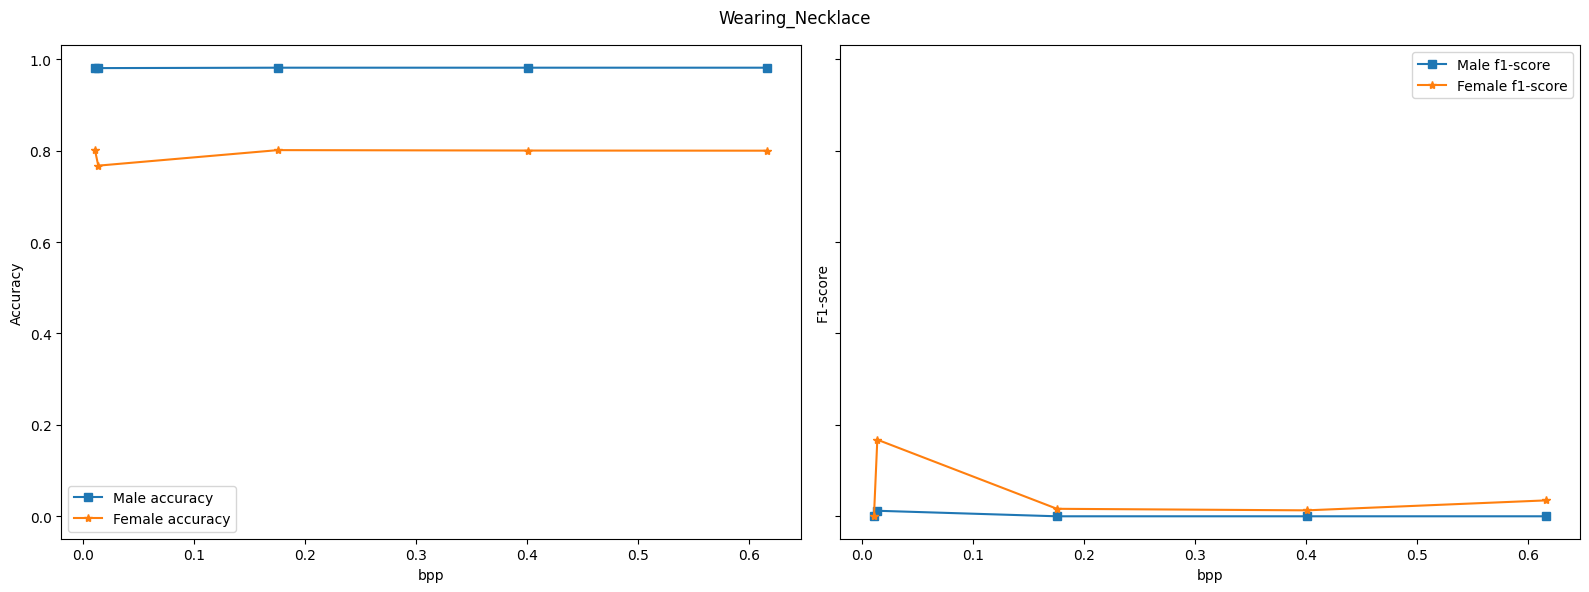

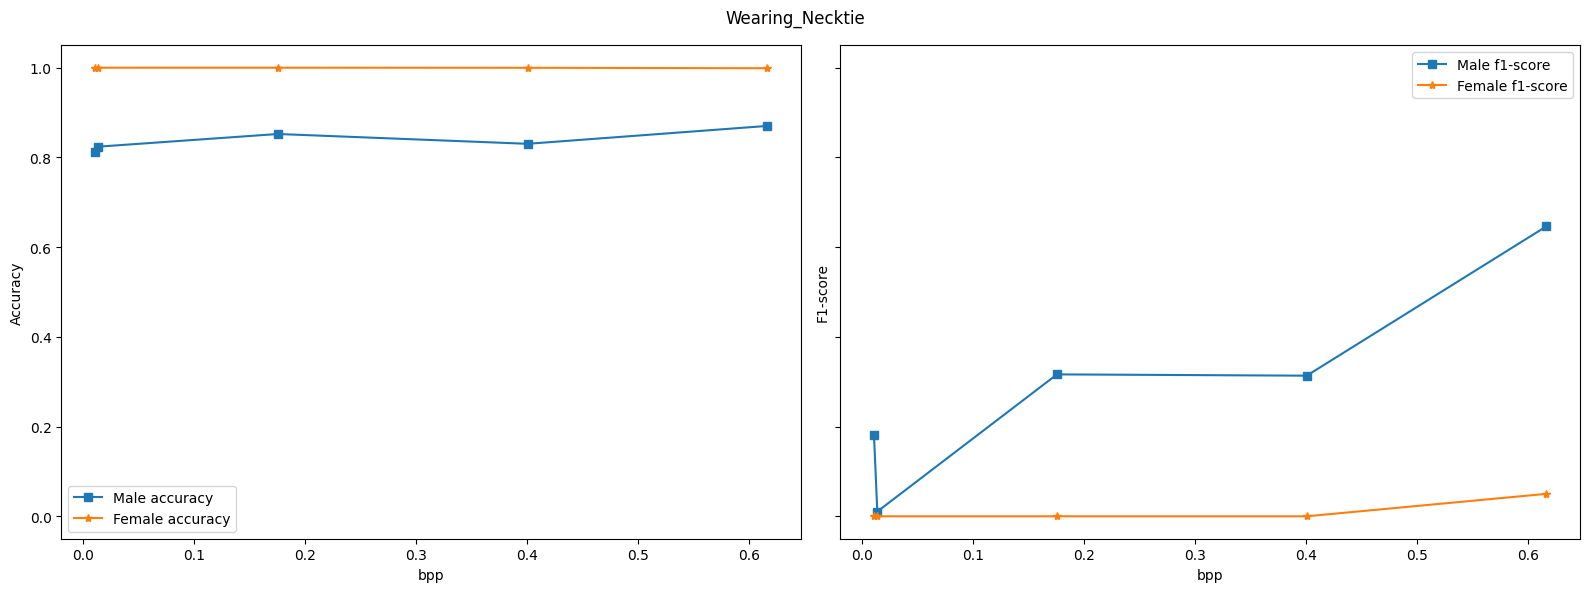

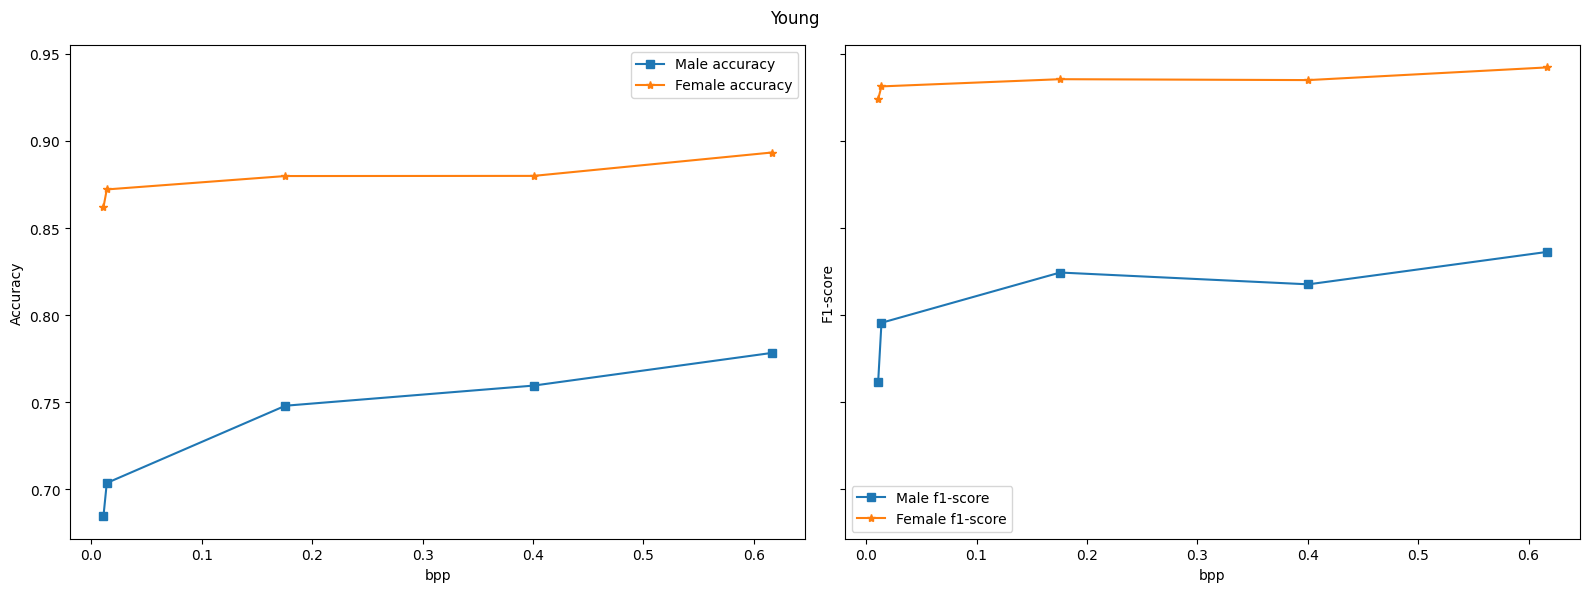

In [27]:
import matplotlib.pyplot as plt

all_metrics_plot_path = '../results/celebA/plots/output model preds'
genders = ['male', 'female']
gender_markers = ['s', '*']
for i, label in enumerate(column_labels):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    for j in range(len(genders)):
        gender_accuracies, gender_f1_scores = [], []
        for k, data_rate in enumerate(data_rates):
            gender_accuracies.append(results['accuracy'][data_rate][j][i])
            gender_f1_scores.append(results['f1'][data_rate][j][i])
    
        axes[0].plot(bpps, gender_accuracies, marker=gender_markers[j], label=f'{genders[j].title()} accuracy')
        axes[1].plot(bpps, gender_f1_scores, marker=gender_markers[j], label=f'{genders[j].title()} f1-score')
        axes[1].set_xlabel('bpp')
        axes[0].set_xlabel('bpp')
        axes[0].set_ylabel('Accuracy')
        axes[1].set_ylabel('F1-score')
        
        axes[0].legend()
        axes[1].legend()
    plt.suptitle(label)
    plt.tight_layout()
    plt.savefig(f'{all_metrics_plot_path}/{label}.png')
    plt.show()